# Autor

**Bernardo José Llamas Verna**

> Data Analyst

> Professional Machine Learning Engineer Certificate by Google (PMLE)

> Python Software Developer

**Contact:**

> [Linkedin](https://www.linkedin.com/in/bernardo-llamas-verna-55bb5343/)

> [Github](https://bernardojosellamasverna.github.io/)


---


# SARIMAX selección de parámetros

## Abstract

El objetivo del presente trabajo es la selección de los parámetros más idóneos para cada uno de los escenarios de selección de variables exógenas definididos en el notebook **Análisis de la Demanda Eléctrica en España (2014-2021)**.

> **Escenario 1:** sin variables exógenas.

> **Escenario 2:** `month`, `hour`, `weekday`, `working_day`.

> **Escenario 3:** `month`, `hour`, `weekday`, `working_day`, `temperatures`.

> **Escenario 4:** `month`, `hour`, `weekday`, `working_day`, `temperatures`, `is_summer`, `is_winter`.


---


In [ ]:
# TODO: añadir qué es SARIMAX (definición en inglés y descripción del modelo).

In [ ]:
# TODO: añadir cuáles son los parámetros y para qué sirven.

In [ ]:
# TODO: añadir cómo funciona la búsqueda de los mejores parámetros mencionando qué es AIC y por qué se usa como parámetro para establecer criterio.

## 0. Importación de librerías, funciones y datasets

In [ ]:
# TODO: delete unused packages
# TODO: order following PEP8

In [1]:
import requests
import json
import numpy as np
import datetime
import string
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import statsmodels.graphics.tsaplots as sgt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import itertools
from itertools import product

from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

import warnings
from google.colab import files

In [2]:
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
from typing import Union
from tqdm.notebook import tqdm
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_SARIMAX(endog , exog, order_list: list, d: int, D: int,  s: int) -> pd.DataFrame:
    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, model.aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [4]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
s = 4

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Carga del Dataset

In [6]:
energy_demand_hour_temp_seasonal_resume_url = 'https://raw.githubusercontent.com/BernardoJoseLlamasVerna/tfm_data_science/feature/refactor_code/version_0/Electric_Demand_Refactor/data/energy_demand_data/energy_demand_datasets/hourly/energy_demand_hour_temp_seasonal_resume.csv'

In [7]:
# energy_demand_hourly = pd.read_csv(energy_datasets + 'hourly/energy_demand_hour_temp_seasonal_resume.csv')
energy_demand_hourly = pd.read_csv(energy_demand_hour_temp_seasonal_resume_url)

energy_demand_hourly['date'] = pd.to_datetime(energy_demand_hourly.date)
energy_demand_hourly.set_index("date", inplace=True)
energy_demand_hourly.index.freq

energy_demand_hourly['month'] = energy_demand_hourly.index.month
energy_demand_hourly = energy_demand_hourly[['month'] + [col for col in energy_demand_hourly.columns if col != 'month']]
energy_demand_hourly.head()

,month,hour,madrid_temp,barcelona_temp,bilbao_temp,sevilla_temp,valencia_temp,weekday,working_day,is_winter,is_summer,value
date,,,,,,,,,,,,
2014-01-01,1,1,4.59854,4.57510,6.95278,9.13394,10.87760,2,0,1,0,140192.0
2014-01-01,1,2,4.65054,4.45498,6.63174,9.30117,10.91030,2,0,1,0,130035.0
2014-01-01,1,3,4.71353,4.49868,7.63442,9.53726,10.86562,2,0,1,0,121152.0
2014-01-01,1,4,4.80654,4.52236,9.08853,9.85757,10.86440,2,0,1,0,115324.0
2014-01-01,1,5,4.91348,4.64297,9.73160,9.99478,10.80825,2,0,1,0,113727.0


In [8]:
# Define the cutoff date for splitting the data
cutoff_date = '2021-12-01'

# Create the training and test datasets
train_dataset = energy_demand_hourly[energy_demand_hourly.index < cutoff_date]
test_dataset = energy_demand_hourly[energy_demand_hourly.index >= cutoff_date]

In [9]:
train_dataset

,month,hour,madrid_temp,barcelona_temp,bilbao_temp,sevilla_temp,valencia_temp,weekday,working_day,is_winter,is_summer,value
date,,,,,,,,,,,,
2014-01-01,1,1,4.59854,4.57510,6.95278,9.13394,10.87760,2,0,1,0,140192.0
2014-01-01,1,2,4.65054,4.45498,6.63174,9.30117,10.91030,2,0,1,0,130035.0
2014-01-01,1,3,4.71353,4.49868,7.63442,9.53726,10.86562,2,0,1,0,121152.0
2014-01-01,1,4,4.80654,4.52236,9.08853,9.85757,10.86440,2,0,1,0,115324.0
2014-01-01,1,5,4.91348,4.64297,9.73160,9.99478,10.80825,2,0,1,0,113727.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-30,11,19,6.08780,8.81190,8.35780,9.53920,11.68813,1,1,0,0,214199.0
2021-11-30,11,20,6.18960,8.07607,8.34830,8.32020,10.96523,1,1,0,0,217299.0
2021-11-30,11,21,6.54116,7.52383,8.52260,7.47890,8.82632,1,1,0,0,212615.0


In [10]:
test_dataset

,month,hour,madrid_temp,barcelona_temp,bilbao_temp,sevilla_temp,valencia_temp,weekday,working_day,is_winter,is_summer,value
date,,,,,,,,,,,,
2021-12-01,12,0,4.29092,6.39224,9.30508,6.51748,7.46620,2,1,0,0,165258.0
2021-12-01,12,1,3.63100,6.20864,9.04043,6.38490,7.49795,2,1,0,0,154859.0
2021-12-01,12,2,2.99233,6.01113,8.75210,5.99648,7.34463,2,1,0,0,147787.0
2021-12-01,12,3,2.40150,5.83486,8.45570,5.58682,7.17837,2,1,0,0,143588.0
2021-12-01,12,4,1.89175,5.74673,8.35780,4.92153,7.05923,2,1,0,0,142830.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-30,12,21,7.99355,9.85050,12.29482,10.49624,9.64540,3,1,1,0,177517.0
2021-12-30,12,22,6.70156,9.27798,11.62173,9.96792,9.12393,3,1,1,0,165247.0
2021-12-30,12,23,5.81900,8.91396,11.03604,9.53480,8.91274,3,1,1,0,149899.0


## 2. Carga del Dataframe de posibles resultados

In [11]:
# TODO: explicar por qué se crea un dataframe con combinaciones de parámetros y resultados vacío

In [12]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
s = 4

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [13]:
parameters_list

[(0, 0, 0, 0),
 (0, 0, 0, 1),
 (0, 0, 0, 2),
 (0, 0, 0, 3),
 (0, 0, 1, 0),
 (0, 0, 1, 1),
 (0, 0, 1, 2),
 (0, 0, 1, 3),
 (0, 0, 2, 0),
 (0, 0, 2, 1),
 (0, 0, 2, 2),
 (0, 0, 2, 3),
 (0, 0, 3, 0),
 (0, 0, 3, 1),
 (0, 0, 3, 2),
 (0, 0, 3, 3),
 (0, 1, 0, 0),
 (0, 1, 0, 1),
 (0, 1, 0, 2),
 (0, 1, 0, 3),
 (0, 1, 1, 0),
 (0, 1, 1, 1),
 (0, 1, 1, 2),
 (0, 1, 1, 3),
 (0, 1, 2, 0),
 (0, 1, 2, 1),
 (0, 1, 2, 2),
 (0, 1, 2, 3),
 (0, 1, 3, 0),
 (0, 1, 3, 1),
 (0, 1, 3, 2),
 (0, 1, 3, 3),
 (0, 2, 0, 0),
 (0, 2, 0, 1),
 (0, 2, 0, 2),
 (0, 2, 0, 3),
 (0, 2, 1, 0),
 (0, 2, 1, 1),
 (0, 2, 1, 2),
 (0, 2, 1, 3),
 (0, 2, 2, 0),
 (0, 2, 2, 1),
 (0, 2, 2, 2),
 (0, 2, 2, 3),
 (0, 2, 3, 0),
 (0, 2, 3, 1),
 (0, 2, 3, 2),
 (0, 2, 3, 3),
 (0, 3, 0, 0),
 (0, 3, 0, 1),
 (0, 3, 0, 2),
 (0, 3, 0, 3),
 (0, 3, 1, 0),
 (0, 3, 1, 1),
 (0, 3, 1, 2),
 (0, 3, 1, 3),
 (0, 3, 2, 0),
 (0, 3, 2, 1),
 (0, 3, 2, 2),
 (0, 3, 2, 3),
 (0, 3, 3, 0),
 (0, 3, 3, 1),
 (0, 3, 3, 2),
 (0, 3, 3, 3),
 (1, 0, 0, 0),
 (1, 0, 0, 1),
 (1, 0, 0,

In [14]:
len(parameters_list)

256

In [15]:
parameters_list[0]

(0, 0, 0, 0)

In [16]:
type(parameters_list[0])

tuple

In [17]:
# Convert each tuple in the list to a list
parameters_list_as_lists = [list(tup) for tup in parameters_list]

In [18]:
results_combination_df = pd.DataFrame({
    '[p,q,P,Q]': parameters_list_as_lists,
    'AIC': np.nan  # Initializing the 'AIC' column with Null (NaN)
})

In [19]:
results_combination_df

,"[p,q,P,Q]",AIC
0,"[0, 0, 0, 0]",NaN
1,"[0, 0, 0, 1]",NaN
2,"[0, 0, 0, 2]",NaN
3,"[0, 0, 0, 3]",NaN
4,"[0, 0, 1, 0]",NaN
...,...,...
251,"[3, 3, 2, 3]",NaN
252,"[3, 3, 3, 0]",NaN
253,"[3, 3, 3, 1]",NaN
254,"[3, 3, 3, 2]",NaN


In [20]:
results_combination_df_url = 'https://raw.githubusercontent.com/BernardoJoseLlamasVerna/tfm_data_science/feature/refactor_code/version_0/Electric_Demand_Refactor/models/SARIMAX/results_combination/results_combination.csv'

In [21]:
results_combination_df = pd.read_csv(results_combination_df_url)

In [22]:
results_combination_df

,"[p,q,P,Q]",AIC
0,"[0, 0, 0, 0]",NaN
1,"[0, 0, 0, 1]",NaN
2,"[0, 0, 0, 2]",NaN
3,"[0, 0, 0, 3]",NaN
4,"[0, 0, 1, 0]",NaN
...,...,...
251,"[3, 3, 2, 3]",NaN
252,"[3, 3, 3, 0]",NaN
253,"[3, 3, 3, 1]",NaN
254,"[3, 3, 3, 2]",NaN


In [23]:
from typing import Union
import pandas as pd
from tqdm import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import ast

def optimize_SARIMAX_by_row(endog: Union[pd.Series, list],
                            exog: Union[pd.Series, list],
                            df: pd.DataFrame,
                            d: int, D: int, s: int,
                            results_csv_name: str,
                            save_every: int = 5) -> pd.DataFrame:

    # Convert '[p,q,P,Q]' to list if it's a string
    df['[p,q,P,Q]'] = df['[p,q,P,Q]'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

    # Iterate through the DataFrame rows
    for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
        # Skip if AIC is already calculated
        if pd.notnull(row['AIC']):
            continue

        try:
            print(f"Starting process using: {row['[p,q,P,Q]']}")
            order = row['[p,q,P,Q]']

            # Fit the SARIMAX model
            model = SARIMAX(
                endog,
                exog,
                order = (order[0], d, order[1]),
                seasonal_order = (order[2], D, order[3], s),
                simple_differencing = False
            ).fit(disp=False)

            # Update the AIC value in the DataFrame
            df.at[idx, 'AIC'] = model.aic

            print(f"AIC value: {model.aic}")
            print("----------------------------------------")

        except Exception as e:
            print(f"An error occurred: {e}")
            continue

        # Save the intermediate results every `save_every` rows
        if (idx + 1) % save_every == 0:
            file_path = f'/content/drive/My Drive/Models/SARIMAX/{results_csv_name}'
            df.to_csv(file_path, index=False)
            print(f"Intermediate results saved to {file_path}")

    # Final save of the results
    df.to_csv(results_csv_name, index=False)
    print(f"Final results saved to {results_csv_name}")

    # Sort the DataFrame by AIC in ascending order
    df = df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return df

## 1. Escenario 1: sin variables exógenas

In [24]:
train_sarimax_1 = train_dataset.copy()

In [25]:
train_sarimax_1

,month,hour,madrid_temp,barcelona_temp,bilbao_temp,sevilla_temp,valencia_temp,weekday,working_day,is_winter,is_summer,value
date,,,,,,,,,,,,
2014-01-01,1,1,4.59854,4.57510,6.95278,9.13394,10.87760,2,0,1,0,140192.0
2014-01-01,1,2,4.65054,4.45498,6.63174,9.30117,10.91030,2,0,1,0,130035.0
2014-01-01,1,3,4.71353,4.49868,7.63442,9.53726,10.86562,2,0,1,0,121152.0
2014-01-01,1,4,4.80654,4.52236,9.08853,9.85757,10.86440,2,0,1,0,115324.0
2014-01-01,1,5,4.91348,4.64297,9.73160,9.99478,10.80825,2,0,1,0,113727.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-30,11,19,6.08780,8.81190,8.35780,9.53920,11.68813,1,1,0,0,214199.0
2021-11-30,11,20,6.18960,8.07607,8.34830,8.32020,10.96523,1,1,0,0,217299.0
2021-11-30,11,21,6.54116,7.52383,8.52260,7.47890,8.82632,1,1,0,0,212615.0


In [26]:
test_sarimax_1 = test_dataset.copy()

In [27]:
test_sarimax_1

,month,hour,madrid_temp,barcelona_temp,bilbao_temp,sevilla_temp,valencia_temp,weekday,working_day,is_winter,is_summer,value
date,,,,,,,,,,,,
2021-12-01,12,0,4.29092,6.39224,9.30508,6.51748,7.46620,2,1,0,0,165258.0
2021-12-01,12,1,3.63100,6.20864,9.04043,6.38490,7.49795,2,1,0,0,154859.0
2021-12-01,12,2,2.99233,6.01113,8.75210,5.99648,7.34463,2,1,0,0,147787.0
2021-12-01,12,3,2.40150,5.83486,8.45570,5.58682,7.17837,2,1,0,0,143588.0
2021-12-01,12,4,1.89175,5.74673,8.35780,4.92153,7.05923,2,1,0,0,142830.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-30,12,21,7.99355,9.85050,12.29482,10.49624,9.64540,3,1,1,0,177517.0
2021-12-30,12,22,6.70156,9.27798,11.62173,9.96792,9.12393,3,1,1,0,165247.0
2021-12-30,12,23,5.81900,8.91396,11.03604,9.53480,8.91274,3,1,1,0,149899.0


In [28]:
exo_train_1 = train_sarimax_1.copy()

del exo_train_1['value']
del exo_train_1['is_summer']
del exo_train_1['is_winter']

del exo_train_1['working_day']
del exo_train_1['weekday']

del exo_train_1['valencia_temp']
del exo_train_1['sevilla_temp']
del exo_train_1['bilbao_temp']
del exo_train_1['barcelona_temp']
del exo_train_1['madrid_temp']

del exo_train_1['hour']
del exo_train_1['month']

In [29]:
exo_train_1

""
date
2014-01-01
2014-01-01
2014-01-01
2014-01-01
2014-01-01
...
2021-11-30
2021-11-30
2021-11-30


In [30]:
del train_sarimax_1['is_summer']
del train_sarimax_1['is_winter']

del train_sarimax_1['working_day']
del train_sarimax_1['weekday']

del train_sarimax_1['valencia_temp']
del train_sarimax_1['sevilla_temp']
del train_sarimax_1['bilbao_temp']
del train_sarimax_1['barcelona_temp']
del train_sarimax_1['madrid_temp']

del train_sarimax_1['hour']
del train_sarimax_1['month']

In [31]:
train_sarimax_1

,value
date,
2014-01-01,140192.0
2014-01-01,130035.0
2014-01-01,121152.0
2014-01-01,115324.0
2014-01-01,113727.0
...,...
2021-11-30,214199.0
2021-11-30,217299.0
2021-11-30,212615.0


In [32]:
results_df_1_url = 'https://raw.githubusercontent.com/BernardoJoseLlamasVerna/tfm_data_science/feature/refactor_code/version_0/Electric_Demand_Refactor/models/SARIMAX/scenario_1/result_df_1.csv'

In [33]:
results_df_1 = pd.read_csv(results_df_1_url)
results_df_1

,"[p,q,P,Q]",AIC
0,"[2, 3, 3, 3]",1.358595e+06
1,"[2, 3, 3, 2]",1.359306e+06
2,"[2, 3, 2, 3]",1.359694e+06
3,"[3, 3, 3, 3]",1.361082e+06
4,"[3, 3, 3, 2]",1.363622e+06
...,...,...
251,"[0, 0, 2, 0]",1.436205e+06
252,"[0, 0, 1, 1]",1.444279e+06
253,"[0, 0, 0, 1]",1.444492e+06
254,"[0, 0, 1, 0]",1.445731e+06


In [34]:
results_df_1 = optimize_SARIMAX_by_row(train_sarimax_1,
                                         None,
                                         results_df_1,
                                         d, D, s,
                                         'results_1',
                                         save_every=1)

100%|██████████| 256/256 [00:00<00:00, 15171.85it/s]

Final results saved to results_1


In [35]:
results_df_1

,"[p,q,P,Q]",AIC
0,"[2, 3, 3, 3]",1.358595e+06
1,"[2, 3, 3, 2]",1.359306e+06
2,"[2, 3, 2, 3]",1.359694e+06
3,"[3, 3, 3, 3]",1.361082e+06
4,"[3, 3, 3, 2]",1.363622e+06
...,...,...
251,"[0, 0, 2, 0]",1.436205e+06
252,"[0, 0, 1, 1]",1.444279e+06
253,"[0, 0, 0, 1]",1.444492e+06
254,"[0, 0, 1, 0]",1.445731e+06


In [36]:
# Save result_df_1 as CSV file
# result_df_1.to_csv('result_df_1.csv', index=False)

In [37]:
# from google.colab import files
# files.download('result_df_1.csv')

In [36]:
# Order by AIC (less value first)
results_df_1.sort_values(by='AIC', ascending=True, inplace=True)

In [37]:
results_df_1

,"[p,q,P,Q]",AIC
0,"[2, 3, 3, 3]",1.358595e+06
1,"[2, 3, 3, 2]",1.359306e+06
2,"[2, 3, 2, 3]",1.359694e+06
3,"[3, 3, 3, 3]",1.361082e+06
4,"[3, 3, 3, 2]",1.363622e+06
...,...,...
251,"[0, 0, 2, 0]",1.436205e+06
252,"[0, 0, 1, 1]",1.444279e+06
253,"[0, 0, 0, 1]",1.444492e+06
254,"[0, 0, 1, 0]",1.445731e+06


## 2. Escenario 2: `month`, `hour`, `weekday`, `working_day`.

In [38]:
train_sarimax_2 = train_dataset.copy()
train_sarimax_2

,month,hour,madrid_temp,barcelona_temp,bilbao_temp,sevilla_temp,valencia_temp,weekday,working_day,is_winter,is_summer,value
date,,,,,,,,,,,,
2014-01-01,1,1,4.59854,4.57510,6.95278,9.13394,10.87760,2,0,1,0,140192.0
2014-01-01,1,2,4.65054,4.45498,6.63174,9.30117,10.91030,2,0,1,0,130035.0
2014-01-01,1,3,4.71353,4.49868,7.63442,9.53726,10.86562,2,0,1,0,121152.0
2014-01-01,1,4,4.80654,4.52236,9.08853,9.85757,10.86440,2,0,1,0,115324.0
2014-01-01,1,5,4.91348,4.64297,9.73160,9.99478,10.80825,2,0,1,0,113727.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-30,11,19,6.08780,8.81190,8.35780,9.53920,11.68813,1,1,0,0,214199.0
2021-11-30,11,20,6.18960,8.07607,8.34830,8.32020,10.96523,1,1,0,0,217299.0
2021-11-30,11,21,6.54116,7.52383,8.52260,7.47890,8.82632,1,1,0,0,212615.0


In [39]:
test_sarimax_2 = test_dataset.copy()
test_sarimax_2

,month,hour,madrid_temp,barcelona_temp,bilbao_temp,sevilla_temp,valencia_temp,weekday,working_day,is_winter,is_summer,value
date,,,,,,,,,,,,
2021-12-01,12,0,4.29092,6.39224,9.30508,6.51748,7.46620,2,1,0,0,165258.0
2021-12-01,12,1,3.63100,6.20864,9.04043,6.38490,7.49795,2,1,0,0,154859.0
2021-12-01,12,2,2.99233,6.01113,8.75210,5.99648,7.34463,2,1,0,0,147787.0
2021-12-01,12,3,2.40150,5.83486,8.45570,5.58682,7.17837,2,1,0,0,143588.0
2021-12-01,12,4,1.89175,5.74673,8.35780,4.92153,7.05923,2,1,0,0,142830.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-30,12,21,7.99355,9.85050,12.29482,10.49624,9.64540,3,1,1,0,177517.0
2021-12-30,12,22,6.70156,9.27798,11.62173,9.96792,9.12393,3,1,1,0,165247.0
2021-12-30,12,23,5.81900,8.91396,11.03604,9.53480,8.91274,3,1,1,0,149899.0


In [40]:
exo_train_2 = train_sarimax_2.copy()

del exo_train_2['value']
del exo_train_2['is_summer']
del exo_train_2['is_winter']

del exo_train_2['valencia_temp']
del exo_train_2['sevilla_temp']
del exo_train_2['bilbao_temp']
del exo_train_2['barcelona_temp']
del exo_train_2['madrid_temp']

In [41]:
exo_train_2

,month,hour,weekday,working_day
date,,,,
2014-01-01,1,1,2,0
2014-01-01,1,2,2,0
2014-01-01,1,3,2,0
2014-01-01,1,4,2,0
2014-01-01,1,5,2,0
...,...,...,...,...
2021-11-30,11,19,1,1
2021-11-30,11,20,1,1
2021-11-30,11,21,1,1


In [42]:
del train_sarimax_2['is_summer']
del train_sarimax_2['is_winter']

del train_sarimax_2['working_day']
del train_sarimax_2['weekday']

del train_sarimax_2['valencia_temp']
del train_sarimax_2['sevilla_temp']
del train_sarimax_2['bilbao_temp']
del train_sarimax_2['barcelona_temp']
del train_sarimax_2['madrid_temp']

del train_sarimax_2['hour']
del train_sarimax_2['month']

In [43]:
train_sarimax_2

,value
date,
2014-01-01,140192.0
2014-01-01,130035.0
2014-01-01,121152.0
2014-01-01,115324.0
2014-01-01,113727.0
...,...
2021-11-30,214199.0
2021-11-30,217299.0
2021-11-30,212615.0


In [44]:
# results_combination_df
results_df_2 = pd.read_csv('/content/drive/My Drive/Models/SARIMAX/results_2')
results_df_2

,"[p,q,P,Q]",AIC
0,"[0, 0, 0, 0]",2.141881e+06
1,"[0, 0, 0, 1]",1.438513e+06
2,"[0, 0, 0, 2]",1.428679e+06
3,"[0, 0, 0, 3]",1.429228e+06
4,"[0, 0, 1, 0]",1.439230e+06
...,...,...
251,"[3, 3, 2, 3]",1.368232e+06
252,"[3, 3, 3, 0]",1.389994e+06
253,"[3, 3, 3, 1]",1.390522e+06
254,"[3, 3, 3, 2]",1.368401e+06


In [30]:
results_df_2 = optimize_SARIMAX_by_row(train_sarimax_2,
                                       exo_train_2,
                                       # results_combination_df,
                                       results_df_2,
                                       d, D, s,
                                       'results_2',
                                       save_every=1)

  0%|          | 0/256 [00:00<?, ?it/s]

Starting process using: [3, 1, 1, 3]


 84%|████████▍ | 216/256 [09:10<01:41,  2.55s/it]

AIC value: 1386302.766045626
----------------------------------------
Intermediate results saved to /content/drive/My Drive/Models/SARIMAX/results_2
Starting process using: [3, 1, 2, 0]


 85%|████████▍ | 217/256 [14:19<02:57,  4.56s/it]

AIC value: 1382573.497836685
----------------------------------------
Intermediate results saved to /content/drive/My Drive/Models/SARIMAX/results_2
Starting process using: [3, 1, 2, 1]


 85%|████████▌ | 218/256 [20:24<05:00,  7.91s/it]

AIC value: 1378351.3793255035
----------------------------------------
Intermediate results saved to /content/drive/My Drive/Models/SARIMAX/results_2
Starting process using: [3, 1, 2, 2]


 86%|████████▌ | 219/256 [26:17<07:40, 12.44s/it]

AIC value: 1381022.3123563037
----------------------------------------
Intermediate results saved to /content/drive/My Drive/Models/SARIMAX/results_2
Starting process using: [3, 1, 2, 3]


 86%|████████▌ | 220/256 [35:41<13:32, 22.58s/it]

AIC value: 1378210.4782569285
----------------------------------------
Intermediate results saved to /content/drive/My Drive/Models/SARIMAX/results_2
Starting process using: [3, 1, 3, 0]


 86%|████████▋ | 221/256 [42:43<19:08, 32.81s/it]

AIC value: 1378419.6728581605
----------------------------------------
Intermediate results saved to /content/drive/My Drive/Models/SARIMAX/results_2
Starting process using: [3, 1, 3, 1]


 87%|████████▋ | 222/256 [50:12<26:54, 47.47s/it]

AIC value: 1375772.354208242
----------------------------------------
Intermediate results saved to /content/drive/My Drive/Models/SARIMAX/results_2
Starting process using: [3, 1, 3, 2]


 87%|████████▋ | 223/256 [58:01<37:14, 67.73s/it]

AIC value: 1378231.5077065423
----------------------------------------
Intermediate results saved to /content/drive/My Drive/Models/SARIMAX/results_2
Starting process using: [3, 1, 3, 3]


 88%|████████▊ | 224/256 [1:06:43<51:39, 96.86s/it]

AIC value: 1376937.211129153
----------------------------------------
Intermediate results saved to /content/drive/My Drive/Models/SARIMAX/results_2
Starting process using: [3, 2, 0, 0]


 88%|████████▊ | 225/256 [1:09:56<54:10, 104.85s/it]

AIC value: 1379137.5949879517
----------------------------------------
Intermediate results saved to /content/drive/My Drive/Models/SARIMAX/results_2
Starting process using: [3, 2, 0, 1]


 88%|████████▊ | 226/256 [1:14:39<1:01:59, 123.99s/it]

An error occurred: LU decomposition error.
Starting process using: [3, 2, 0, 2]


 89%|████████▊ | 227/256 [1:20:29<1:14:25, 153.98s/it]

AIC value: 1379882.1943701315
----------------------------------------
Intermediate results saved to /content/drive/My Drive/Models/SARIMAX/results_2
Starting process using: [3, 2, 0, 3]


 89%|████████▉ | 228/256 [1:29:14<1:39:24, 213.02s/it]

AIC value: 1396310.0840749478
----------------------------------------
Intermediate results saved to /content/drive/My Drive/Models/SARIMAX/results_2
Starting process using: [3, 2, 1, 0]


 89%|████████▉ | 229/256 [1:33:54<1:41:28, 225.50s/it]

AIC value: 1378825.819854415
----------------------------------------
Intermediate results saved to /content/drive/My Drive/Models/SARIMAX/results_2
Starting process using: [3, 2, 1, 1]


 90%|████████▉ | 230/256 [1:38:33<1:42:32, 236.64s/it]

AIC value: 1391818.2812888029
----------------------------------------
Intermediate results saved to /content/drive/My Drive/Models/SARIMAX/results_2
Starting process using: [3, 2, 1, 2]


 90%|█████████ | 231/256 [1:45:02<1:53:15, 271.81s/it]

AIC value: 1399897.5179137543
----------------------------------------
Intermediate results saved to /content/drive/My Drive/Models/SARIMAX/results_2
Starting process using: [3, 2, 1, 3]


 91%|█████████ | 232/256 [1:53:21<2:11:14, 328.09s/it]

AIC value: 1385891.0756305587
----------------------------------------
Intermediate results saved to /content/drive/My Drive/Models/SARIMAX/results_2
Starting process using: [3, 2, 2, 0]


 91%|█████████ | 233/256 [2:00:00<2:12:48, 346.48s/it]

AIC value: 1396711.7280447262
----------------------------------------
Intermediate results saved to /content/drive/My Drive/Models/SARIMAX/results_2
Starting process using: [3, 2, 2, 1]


 91%|█████████▏| 234/256 [2:06:48<2:13:11, 363.27s/it]

AIC value: 1395309.630433948
----------------------------------------
Intermediate results saved to /content/drive/My Drive/Models/SARIMAX/results_2
Starting process using: [3, 2, 2, 2]


 92%|█████████▏| 235/256 [2:14:07<2:14:32, 384.42s/it]

AIC value: 1376758.2750143758
----------------------------------------
Intermediate results saved to /content/drive/My Drive/Models/SARIMAX/results_2
Starting process using: [3, 2, 2, 3]


 92%|█████████▏| 236/256 [2:23:12<2:23:27, 430.36s/it]

AIC value: 1376735.8497724957
----------------------------------------
Intermediate results saved to /content/drive/My Drive/Models/SARIMAX/results_2
Starting process using: [3, 2, 3, 0]


 93%|█████████▎| 237/256 [2:30:47<2:18:29, 437.35s/it]

AIC value: 1393208.2008786094
----------------------------------------
Intermediate results saved to /content/drive/My Drive/Models/SARIMAX/results_2
Starting process using: [3, 2, 3, 1]


 93%|█████████▎| 238/256 [2:39:54<2:20:48, 469.36s/it]

AIC value: 1393005.5060561388
----------------------------------------
Intermediate results saved to /content/drive/My Drive/Models/SARIMAX/results_2
Starting process using: [3, 2, 3, 2]


 93%|█████████▎| 239/256 [2:49:19<2:21:02, 497.77s/it]

AIC value: 1374927.29247621
----------------------------------------
Intermediate results saved to /content/drive/My Drive/Models/SARIMAX/results_2
Starting process using: [3, 2, 3, 3]


 94%|█████████▍| 240/256 [2:59:02<2:19:27, 523.00s/it]

AIC value: 1374328.7222625169
----------------------------------------
Intermediate results saved to /content/drive/My Drive/Models/SARIMAX/results_2
Starting process using: [3, 3, 0, 0]


 94%|█████████▍| 241/256 [3:02:47<1:48:32, 434.16s/it]

AIC value: 1376148.6164343434
----------------------------------------
Intermediate results saved to /content/drive/My Drive/Models/SARIMAX/results_2
Starting process using: [3, 3, 0, 1]


 95%|█████████▍| 242/256 [3:07:55<1:32:31, 396.52s/it]

AIC value: 1376985.3332179657
----------------------------------------
Intermediate results saved to /content/drive/My Drive/Models/SARIMAX/results_2
Starting process using: [3, 3, 0, 2]


 95%|█████████▍| 243/256 [3:15:13<1:28:37, 409.02s/it]

AIC value: 1377081.3425867527
----------------------------------------
Intermediate results saved to /content/drive/My Drive/Models/SARIMAX/results_2
Starting process using: [3, 3, 0, 3]


 95%|█████████▌| 244/256 [3:24:17<1:29:54, 449.56s/it]

AIC value: 1376206.619718138
----------------------------------------
Intermediate results saved to /content/drive/My Drive/Models/SARIMAX/results_2
Starting process using: [3, 3, 1, 0]


 96%|█████████▌| 245/256 [3:28:44<1:12:22, 394.74s/it]

AIC value: 1375875.6265580272
----------------------------------------
Intermediate results saved to /content/drive/My Drive/Models/SARIMAX/results_2
Starting process using: [3, 3, 1, 1]


 96%|█████████▌| 246/256 [3:34:00<1:01:50, 371.05s/it]

AIC value: 1375087.7132555535
----------------------------------------
Intermediate results saved to /content/drive/My Drive/Models/SARIMAX/results_2
Starting process using: [3, 3, 1, 2]


 96%|█████████▋| 247/256 [3:41:09<58:18, 388.67s/it]  

AIC value: 1385698.2718917194
----------------------------------------
Intermediate results saved to /content/drive/My Drive/Models/SARIMAX/results_2
Starting process using: [3, 3, 1, 3]


 97%|█████████▋| 248/256 [3:51:16<1:00:32, 454.00s/it]

AIC value: 1387579.281350387
----------------------------------------
Intermediate results saved to /content/drive/My Drive/Models/SARIMAX/results_2
Starting process using: [3, 3, 2, 0]


 97%|█████████▋| 249/256 [3:57:32<50:15, 430.78s/it]  

AIC value: 1375533.8919572802
----------------------------------------
Intermediate results saved to /content/drive/My Drive/Models/SARIMAX/results_2
Starting process using: [3, 3, 2, 1]


 98%|█████████▊| 250/256 [4:04:15<42:14, 422.33s/it]

AIC value: 1383784.8422342478
----------------------------------------
Intermediate results saved to /content/drive/My Drive/Models/SARIMAX/results_2
Starting process using: [3, 3, 2, 2]


 98%|█████████▊| 251/256 [4:13:29<38:28, 461.66s/it]

AIC value: 1378060.457097818
----------------------------------------
Intermediate results saved to /content/drive/My Drive/Models/SARIMAX/results_2
Starting process using: [3, 3, 2, 3]


 98%|█████████▊| 252/256 [4:24:19<34:32, 518.24s/it]

AIC value: 1368231.5406968612
----------------------------------------
Intermediate results saved to /content/drive/My Drive/Models/SARIMAX/results_2
Starting process using: [3, 3, 3, 0]


 99%|█████████▉| 253/256 [4:32:58<25:55, 518.46s/it]

AIC value: 1389993.8953689907
----------------------------------------
Intermediate results saved to /content/drive/My Drive/Models/SARIMAX/results_2
Starting process using: [3, 3, 3, 1]


 99%|█████████▉| 254/256 [4:41:53<17:26, 523.40s/it]

AIC value: 1390522.0722340909
----------------------------------------
Intermediate results saved to /content/drive/My Drive/Models/SARIMAX/results_2
Starting process using: [3, 3, 3, 2]


100%|█████████▉| 255/256 [4:51:30<08:59, 539.56s/it]

AIC value: 1368401.14236602
----------------------------------------
Intermediate results saved to /content/drive/My Drive/Models/SARIMAX/results_2
Starting process using: [3, 3, 3, 3]


100%|██████████| 256/256 [5:03:41<00:00, 71.18s/it] 

AIC value: 1365587.6305644668
----------------------------------------
Intermediate results saved to /content/drive/My Drive/Models/SARIMAX/results_2
Final results saved to results_2


In [31]:
# Save result_df_1 as CSV file
results_df_2.to_csv('results_df_2.csv', index=False)

from google.colab import files
files.download('results_df_2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [45]:
results_df_2_url = 'https://raw.githubusercontent.com/BernardoJoseLlamasVerna/tfm_data_science/refs/heads/feature/refactor_code/version_0/Electric_Demand_Refactor/models/SARIMAX/scenario_2/results_df_2.csv'

In [46]:
results_df_2 = pd.read_csv(results_df_2_url)
results_df_2

,"[p,q,P,Q]",AIC
0,"[3, 3, 3, 3]",1.365588e+06
1,"[3, 3, 2, 3]",1.368232e+06
2,"[3, 3, 3, 2]",1.368401e+06
3,"[2, 3, 3, 2]",1.374093e+06
4,"[3, 2, 3, 3]",1.374329e+06
...,...,...
251,"[0, 0, 1, 1]",1.437620e+06
252,"[0, 0, 0, 1]",1.438513e+06
253,"[0, 0, 1, 0]",1.439230e+06
254,"[0, 0, 0, 0]",2.141881e+06


In [47]:
# Order by AIC (less value first)
results_df_2.sort_values(by='AIC', ascending=True, inplace=True)

In [48]:
results_df_2

,"[p,q,P,Q]",AIC
0,"[3, 3, 3, 3]",1.365588e+06
1,"[3, 3, 2, 3]",1.368232e+06
2,"[3, 3, 3, 2]",1.368401e+06
3,"[2, 3, 3, 2]",1.374093e+06
4,"[3, 2, 3, 3]",1.374329e+06
...,...,...
251,"[0, 0, 1, 1]",1.437620e+06
252,"[0, 0, 0, 1]",1.438513e+06
253,"[0, 0, 1, 0]",1.439230e+06
254,"[0, 0, 0, 0]",2.141881e+06


## 3. Escenario 3: `month`, `hour`, `weekday`, `working_day`, `temperatures`.

In [49]:
train_sarimax_3 = train_dataset.copy()
train_sarimax_3

,month,hour,madrid_temp,barcelona_temp,bilbao_temp,sevilla_temp,valencia_temp,weekday,working_day,is_winter,is_summer,value
date,,,,,,,,,,,,
2014-01-01,1,1,4.59854,4.57510,6.95278,9.13394,10.87760,2,0,1,0,140192.0
2014-01-01,1,2,4.65054,4.45498,6.63174,9.30117,10.91030,2,0,1,0,130035.0
2014-01-01,1,3,4.71353,4.49868,7.63442,9.53726,10.86562,2,0,1,0,121152.0
2014-01-01,1,4,4.80654,4.52236,9.08853,9.85757,10.86440,2,0,1,0,115324.0
2014-01-01,1,5,4.91348,4.64297,9.73160,9.99478,10.80825,2,0,1,0,113727.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-30,11,19,6.08780,8.81190,8.35780,9.53920,11.68813,1,1,0,0,214199.0
2021-11-30,11,20,6.18960,8.07607,8.34830,8.32020,10.96523,1,1,0,0,217299.0
2021-11-30,11,21,6.54116,7.52383,8.52260,7.47890,8.82632,1,1,0,0,212615.0


In [50]:
test_sarimax_3 = test_dataset.copy()
test_sarimax_3

,month,hour,madrid_temp,barcelona_temp,bilbao_temp,sevilla_temp,valencia_temp,weekday,working_day,is_winter,is_summer,value
date,,,,,,,,,,,,
2021-12-01,12,0,4.29092,6.39224,9.30508,6.51748,7.46620,2,1,0,0,165258.0
2021-12-01,12,1,3.63100,6.20864,9.04043,6.38490,7.49795,2,1,0,0,154859.0
2021-12-01,12,2,2.99233,6.01113,8.75210,5.99648,7.34463,2,1,0,0,147787.0
2021-12-01,12,3,2.40150,5.83486,8.45570,5.58682,7.17837,2,1,0,0,143588.0
2021-12-01,12,4,1.89175,5.74673,8.35780,4.92153,7.05923,2,1,0,0,142830.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-30,12,21,7.99355,9.85050,12.29482,10.49624,9.64540,3,1,1,0,177517.0
2021-12-30,12,22,6.70156,9.27798,11.62173,9.96792,9.12393,3,1,1,0,165247.0
2021-12-30,12,23,5.81900,8.91396,11.03604,9.53480,8.91274,3,1,1,0,149899.0


In [51]:
exo_train_3 = train_sarimax_3.copy()

del exo_train_3['value']
del exo_train_3['is_summer']
del exo_train_3['is_winter']

In [52]:
exo_train_3

,month,hour,madrid_temp,barcelona_temp,bilbao_temp,sevilla_temp,valencia_temp,weekday,working_day
date,,,,,,,,,
2014-01-01,1,1,4.59854,4.57510,6.95278,9.13394,10.87760,2,0
2014-01-01,1,2,4.65054,4.45498,6.63174,9.30117,10.91030,2,0
2014-01-01,1,3,4.71353,4.49868,7.63442,9.53726,10.86562,2,0
2014-01-01,1,4,4.80654,4.52236,9.08853,9.85757,10.86440,2,0
2014-01-01,1,5,4.91348,4.64297,9.73160,9.99478,10.80825,2,0
...,...,...,...,...,...,...,...,...,...
2021-11-30,11,19,6.08780,8.81190,8.35780,9.53920,11.68813,1,1
2021-11-30,11,20,6.18960,8.07607,8.34830,8.32020,10.96523,1,1
2021-11-30,11,21,6.54116,7.52383,8.52260,7.47890,8.82632,1,1


In [53]:
del train_sarimax_3['is_summer']
del train_sarimax_3['is_winter']

del train_sarimax_3['working_day']
del train_sarimax_3['weekday']

del train_sarimax_3['valencia_temp']
del train_sarimax_3['sevilla_temp']
del train_sarimax_3['bilbao_temp']
del train_sarimax_3['barcelona_temp']
del train_sarimax_3['madrid_temp']

del train_sarimax_3['hour']
del train_sarimax_3['month']

In [54]:
train_sarimax_3

,value
date,
2014-01-01,140192.0
2014-01-01,130035.0
2014-01-01,121152.0
2014-01-01,115324.0
2014-01-01,113727.0
...,...
2021-11-30,214199.0
2021-11-30,217299.0
2021-11-30,212615.0


In [30]:
# result_df_3 = optimize_SARIMAX(train_sarimax_3, exo_train_3, parameters_list, d, D, s)

In [31]:
# results_combination_df
results_df_3 = pd.read_csv('/content/drive/My Drive/Models/SARIMAX/results_3')
results_df_3

,"[p,q,P,Q]",AIC
0,"[0, 0, 0, 0]",2.131049e+06
1,"[0, 0, 0, 1]",1.421039e+06
2,"[0, 0, 0, 2]",1.420723e+06
3,"[0, 0, 0, 3]",1.416207e+06
4,"[0, 0, 1, 0]",1.425193e+06
...,...,...
251,"[3, 3, 2, 3]",NaN
252,"[3, 3, 3, 0]",NaN
253,"[3, 3, 3, 1]",NaN
254,"[3, 3, 3, 2]",NaN


In [32]:
results_df_3 = optimize_SARIMAX_by_row(train_sarimax_3,
                                       exo_train_3,
                                       # results_combination_df,
                                       results_df_3,
                                       d, D, s,
                                       'results_3',
                                       save_every=1)

  0%|          | 0/256 [00:00<?, ?it/s]

Starting process using: [3, 3, 1, 3]


 97%|█████████▋| 248/256 [14:22<00:27,  3.48s/it]

AIC value: 1379558.3440120937
----------------------------------------
Intermediate results saved to /content/drive/My Drive/Models/SARIMAX/results_3
Starting process using: [3, 3, 2, 0]


 97%|█████████▋| 249/256 [22:49<00:44,  6.36s/it]

AIC value: 1378723.285538437
----------------------------------------
Intermediate results saved to /content/drive/My Drive/Models/SARIMAX/results_3
Starting process using: [3, 3, 2, 1]


 98%|█████████▊| 250/256 [32:33<01:06, 11.05s/it]

AIC value: 1377360.4332014204
----------------------------------------
Intermediate results saved to /content/drive/My Drive/Models/SARIMAX/results_3
Starting process using: [3, 3, 2, 2]


 98%|█████████▊| 251/256 [42:48<01:29, 17.97s/it]

AIC value: 1367611.7630903982
----------------------------------------
Intermediate results saved to /content/drive/My Drive/Models/SARIMAX/results_3
Starting process using: [3, 3, 2, 3]


 98%|█████████▊| 252/256 [56:58<02:05, 31.37s/it]

AIC value: 1366378.9075668291
----------------------------------------
Intermediate results saved to /content/drive/My Drive/Models/SARIMAX/results_3
Starting process using: [3, 3, 3, 0]


 99%|█████████▉| 253/256 [1:07:10<02:13, 44.43s/it]

AIC value: 1385948.180696133
----------------------------------------
Intermediate results saved to /content/drive/My Drive/Models/SARIMAX/results_3
Starting process using: [3, 3, 3, 1]


 99%|█████████▉| 254/256 [1:19:01<02:10, 65.19s/it]

AIC value: 1377735.0206849382
----------------------------------------
Intermediate results saved to /content/drive/My Drive/Models/SARIMAX/results_3
Starting process using: [3, 3, 3, 2]


100%|█████████▉| 255/256 [1:30:09<01:30, 90.85s/it]

AIC value: 1367527.6523470145
----------------------------------------
Intermediate results saved to /content/drive/My Drive/Models/SARIMAX/results_3
Starting process using: [3, 3, 3, 3]


100%|██████████| 256/256 [1:44:27<00:00, 24.48s/it] 

AIC value: 1364757.8832307172
----------------------------------------
Intermediate results saved to /content/drive/My Drive/Models/SARIMAX/results_3
Final results saved to results_3


In [33]:
# Save result_df_3 as CSV file
results_df_3.to_csv('results_df_3.csv', index=False)

from google.colab import files
files.download('results_df_3.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [55]:
results_df_3 = pd.read_csv('https://raw.githubusercontent.com/BernardoJoseLlamasVerna/tfm_data_science/refs/heads/feature/refactor_code/version_0/Electric_Demand_Refactor/models/SARIMAX/scenario_3/results_df_3.csv')
results_df_3

,"[p,q,P,Q]",AIC
0,"[3, 0, 1, 3]",3.400000e+01
1,"[2, 3, 3, 3]",1.363723e+06
2,"[3, 3, 3, 3]",1.364758e+06
3,"[2, 3, 2, 3]",1.364811e+06
4,"[2, 3, 3, 2]",1.365063e+06
...,...,...
251,"[0, 0, 0, 2]",1.420723e+06
252,"[0, 0, 0, 1]",1.421039e+06
253,"[0, 0, 1, 1]",1.422078e+06
254,"[0, 0, 1, 0]",1.425193e+06


In [56]:
# Order by AIC (less value first)
results_df_3.sort_values(by='AIC', ascending=True, inplace=True)
results_df_3

,"[p,q,P,Q]",AIC
0,"[3, 0, 1, 3]",3.400000e+01
1,"[2, 3, 3, 3]",1.363723e+06
2,"[3, 3, 3, 3]",1.364758e+06
3,"[2, 3, 2, 3]",1.364811e+06
4,"[2, 3, 3, 2]",1.365063e+06
...,...,...
251,"[0, 0, 0, 2]",1.420723e+06
252,"[0, 0, 0, 1]",1.421039e+06
253,"[0, 0, 1, 1]",1.422078e+06
254,"[0, 0, 1, 0]",1.425193e+06


## 4. Escenario 4: `month`, `hour`, `weekday`, `working_day`, `temperatures`, `is_summer`, `is_winter`.

In [57]:
train_sarimax_4 = train_dataset.copy()
train_sarimax_4

,month,hour,madrid_temp,barcelona_temp,bilbao_temp,sevilla_temp,valencia_temp,weekday,working_day,is_winter,is_summer,value
date,,,,,,,,,,,,
2014-01-01,1,1,4.59854,4.57510,6.95278,9.13394,10.87760,2,0,1,0,140192.0
2014-01-01,1,2,4.65054,4.45498,6.63174,9.30117,10.91030,2,0,1,0,130035.0
2014-01-01,1,3,4.71353,4.49868,7.63442,9.53726,10.86562,2,0,1,0,121152.0
2014-01-01,1,4,4.80654,4.52236,9.08853,9.85757,10.86440,2,0,1,0,115324.0
2014-01-01,1,5,4.91348,4.64297,9.73160,9.99478,10.80825,2,0,1,0,113727.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-30,11,19,6.08780,8.81190,8.35780,9.53920,11.68813,1,1,0,0,214199.0
2021-11-30,11,20,6.18960,8.07607,8.34830,8.32020,10.96523,1,1,0,0,217299.0
2021-11-30,11,21,6.54116,7.52383,8.52260,7.47890,8.82632,1,1,0,0,212615.0


In [58]:
test_sarimax_4 = test_dataset.copy()
test_sarimax_4

,month,hour,madrid_temp,barcelona_temp,bilbao_temp,sevilla_temp,valencia_temp,weekday,working_day,is_winter,is_summer,value
date,,,,,,,,,,,,
2021-12-01,12,0,4.29092,6.39224,9.30508,6.51748,7.46620,2,1,0,0,165258.0
2021-12-01,12,1,3.63100,6.20864,9.04043,6.38490,7.49795,2,1,0,0,154859.0
2021-12-01,12,2,2.99233,6.01113,8.75210,5.99648,7.34463,2,1,0,0,147787.0
2021-12-01,12,3,2.40150,5.83486,8.45570,5.58682,7.17837,2,1,0,0,143588.0
2021-12-01,12,4,1.89175,5.74673,8.35780,4.92153,7.05923,2,1,0,0,142830.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-30,12,21,7.99355,9.85050,12.29482,10.49624,9.64540,3,1,1,0,177517.0
2021-12-30,12,22,6.70156,9.27798,11.62173,9.96792,9.12393,3,1,1,0,165247.0
2021-12-30,12,23,5.81900,8.91396,11.03604,9.53480,8.91274,3,1,1,0,149899.0


In [59]:
exo_train_4 = train_sarimax_4.copy()

del exo_train_4['value']

In [60]:
exo_train_4

,month,hour,madrid_temp,barcelona_temp,bilbao_temp,sevilla_temp,valencia_temp,weekday,working_day,is_winter,is_summer
date,,,,,,,,,,,
2014-01-01,1,1,4.59854,4.57510,6.95278,9.13394,10.87760,2,0,1,0
2014-01-01,1,2,4.65054,4.45498,6.63174,9.30117,10.91030,2,0,1,0
2014-01-01,1,3,4.71353,4.49868,7.63442,9.53726,10.86562,2,0,1,0
2014-01-01,1,4,4.80654,4.52236,9.08853,9.85757,10.86440,2,0,1,0
2014-01-01,1,5,4.91348,4.64297,9.73160,9.99478,10.80825,2,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2021-11-30,11,19,6.08780,8.81190,8.35780,9.53920,11.68813,1,1,0,0
2021-11-30,11,20,6.18960,8.07607,8.34830,8.32020,10.96523,1,1,0,0
2021-11-30,11,21,6.54116,7.52383,8.52260,7.47890,8.82632,1,1,0,0


In [61]:
del train_sarimax_4['is_summer']
del train_sarimax_4['is_winter']

del train_sarimax_4['working_day']
del train_sarimax_4['weekday']

del train_sarimax_4['valencia_temp']
del train_sarimax_4['sevilla_temp']
del train_sarimax_4['bilbao_temp']
del train_sarimax_4['barcelona_temp']
del train_sarimax_4['madrid_temp']

del train_sarimax_4['hour']
del train_sarimax_4['month']

In [62]:
train_sarimax_4

,value
date,
2014-01-01,140192.0
2014-01-01,130035.0
2014-01-01,121152.0
2014-01-01,115324.0
2014-01-01,113727.0
...,...
2021-11-30,214199.0
2021-11-30,217299.0
2021-11-30,212615.0


In [63]:
# result_df_4 = optimize_SARIMAX(train_sarimax_4, exo_train_4, parameters_list, d, D, s)

In [64]:
# results_combination_df
results_df_4 = pd.read_csv('/content/drive/My Drive/Models/SARIMAX/results_4')
results_df_4

,"[p,q,P,Q]",AIC
0,"[0, 0, 0, 0]",2.131041e+06
1,"[0, 0, 0, 1]",1.421032e+06
2,"[0, 0, 0, 2]",1.420714e+06
3,"[0, 0, 0, 3]",1.416192e+06
4,"[0, 0, 1, 0]",1.425187e+06
...,...,...
251,"[3, 3, 2, 3]",1.366265e+06
252,"[3, 3, 3, 0]",1.378958e+06
253,"[3, 3, 3, 1]",1.385833e+06
254,"[3, 3, 3, 2]",1.367314e+06


In [65]:
results_df_4 = optimize_SARIMAX_by_row(train_sarimax_4,
                                       exo_train_4,
                                       # results_combination_df,
                                       results_df_4,
                                       d, D, s,
                                       'results_4',
                                       save_every=1)

100%|██████████| 256/256 [00:00<00:00, 14365.40it/s]

Final results saved to results_4


In [33]:
# Save result_df_4 as CSV file
results_df_4.to_csv('results_df_4.csv', index=False)

In [34]:
from google.colab import files
files.download('results_df_4.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [66]:
results_df_4 = pd.read_csv("https://raw.githubusercontent.com/BernardoJoseLlamasVerna/tfm_data_science/refs/heads/feature/refactor_code/version_0/Electric_Demand_Refactor/models/SARIMAX/scenario_4/results_df_4.csv")

In [67]:
# Order by AIC (less value first)
results_df_4.sort_values(by='AIC', ascending=True, inplace=True)
results_df_4

,"[p,q,P,Q]",AIC
0,"[2, 3, 3, 3]",1.362548e+06
1,"[3, 3, 3, 3]",1.364014e+06
2,"[2, 3, 3, 2]",1.364368e+06
3,"[2, 3, 2, 3]",1.364934e+06
4,"[3, 2, 3, 3]",1.365162e+06
...,...,...
251,"[0, 0, 0, 2]",1.420714e+06
252,"[0, 0, 0, 1]",1.421032e+06
253,"[0, 0, 1, 1]",1.422072e+06
254,"[0, 0, 1, 0]",1.425187e+06


In [ ]:
############################################

In [ ]:
EPSILON = 1e-10

def _error(actual: np.ndarray, predicted: np.ndarray):
    """ Simple error """
    return actual - predicted

def _naive_forecasting(actual: np.ndarray, seasonality: int = 1):
    """ Naive forecasting method which just repeats previous samples """
    return actual[:-seasonality]

def _relative_error(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """ Relative Error """
    if benchmark is None or isinstance(benchmark, int):
        # If no benchmark prediction provided - use naive forecasting
        if not isinstance(benchmark, int):
            seasonality = 1
        else:
            seasonality = benchmark
        return _error(actual[seasonality:], predicted[seasonality:]) /\
               (_error(actual[seasonality:], _naive_forecasting(actual, seasonality)) + EPSILON)

    return _error(actual, predicted) / (_error(actual, benchmark) + EPSILON)

def _geometric_mean(a, axis=0, dtype=None):
    """ Geometric mean """
    if not isinstance(a, np.ndarray):  # if not an ndarray object attempt to convert it
        log_a = np.log(np.array(a, dtype=dtype))
    elif dtype:  # Must change the default dtype allowing array type
        if isinstance(a, np.ma.MaskedArray):
            log_a = np.log(np.ma.asarray(a, dtype=dtype))
        else:
            log_a = np.log(np.asarray(a, dtype=dtype))
    else:
        log_a = np.log(a)
    return np.exp(log_a.mean(axis=axis))

def gmrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """ Geometric Mean Relative Absolute Error """
    return _geometric_mean(np.abs(_relative_error(actual, predicted, benchmark)))

def mdrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """ Median Relative Absolute Error """
    return np.median(np.abs(_relative_error(actual, predicted, benchmark)))

def mase(training_series, testing_series, prediction_series):
    n = training_series.shape[0]
    d = np.abs(  np.diff( training_series) ).sum()/(n-1)

    errors = np.abs(testing_series - prediction_series )
    return errors.mean()/d

def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

In [ ]:
energy_demand_daily = pd.read_csv('demanda_electrica_diaria.csv')
energy_demand_daily.set_index("date", inplace=True)

energy_demand_daily.index.freq = 'D'


energy_demand_daily

,value,weekday,working_day
date,,,
2014-01-01,3315035.0,2,0
2014-01-02,4059590.0,3,1
2014-01-03,4098986.0,4,1
2014-01-04,3867911.0,5,1
2014-01-05,3648038.0,6,1
...,...,...,...
2021-12-27,3686647.0,0,1
2021-12-28,3729169.0,1,1
2021-12-29,3692921.0,2,1


In [ ]:
energy_demand_daily_temp = pd.read_csv('demanda_day_temp_resume_total.csv')
energy_demand_daily_temp.set_index("date", inplace=True)

energy_demand_daily_temp.index.freq = 'D'

energy_demand_daily_temp

,value,weekday,working_day,madrid_temp,barcelona_temp,bilbao_temp,sevilla_temp,valencia_temp
date,,,,,,,,
2014-01-01,3315035.0,2.0,0.0,6.785193,8.006851,11.418970,12.184413,13.189499
2014-01-02,4059590.0,3.0,1.0,9.109185,10.764683,12.935602,14.524325,15.136449
2014-01-03,4098986.0,4.0,1.0,9.776889,11.935958,13.029657,15.653018,16.565861
2014-01-04,3867911.0,5.0,1.0,6.703811,11.307489,9.814500,14.106683,14.699295
2014-01-05,3648038.0,6.0,1.0,5.285333,8.682916,9.971085,10.653680,10.970076
...,...,...,...,...,...,...,...,...
2021-12-27,3686647.0,0.0,1.0,11.606002,13.531011,14.285517,17.009720,17.443636
2021-12-28,3729169.0,1.0,1.0,9.792129,14.261092,14.133620,16.015375,16.007968
2021-12-29,3692921.0,2.0,1.0,8.401157,13.250848,12.936356,13.320164,15.173263


In [ ]:
energy_demand_daily_temp_seasonal = pd.read_csv('demanda_day_temp_seasonal_resume.csv')
energy_demand_daily_temp_seasonal.set_index("date", inplace=True)

energy_demand_daily_temp_seasonal.index.freq = 'D'

energy_demand_daily_temp_seasonal

,value,weekday,working_day,madrid_temp,barcelona_temp,bilbao_temp,sevilla_temp,valencia_temp,is_winter,is_summer
date,,,,,,,,,,
2014-01-01,3315035.0,2.0,0.0,6.785193,8.006851,11.418970,12.184413,13.189499,1,0
2014-01-02,4059590.0,3.0,1.0,9.109185,10.764683,12.935602,14.524325,15.136449,1,0
2014-01-03,4098986.0,4.0,1.0,9.776889,11.935958,13.029657,15.653018,16.565861,1,0
2014-01-04,3867911.0,5.0,1.0,6.703811,11.307489,9.814500,14.106683,14.699295,1,0
2014-01-05,3648038.0,6.0,1.0,5.285333,8.682916,9.971085,10.653680,10.970076,1,0
...,...,...,...,...,...,...,...,...,...,...
2021-12-27,3686647.0,0.0,1.0,11.606002,13.531011,14.285517,17.009720,17.443636,1,0
2021-12-28,3729169.0,1.0,1.0,9.792129,14.261092,14.133620,16.015375,16.007968,1,0
2021-12-29,3692921.0,2.0,1.0,8.401157,13.250848,12.936356,13.320164,15.173263,1,0


In [ ]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_SARIMAX(endog , exog, order_list: list, d: int, D: int,  s: int) -> pd.DataFrame:

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(
                endog,
                # exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, model.aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

### Sin variables exógenas

In [ ]:
train_sarimax = energy_demand_daily.loc['2014':'2021']

In [ ]:
test_sarimax = energy_demand_daily.loc['2021':'2022']

In [ ]:
exo_train = train_sarimax

del exo_train['value']
del exo_train['weekday']
del exo_train['working_day']

exo_train

""
date
2014-01-01
2014-01-02
2014-01-03
2014-01-04
2014-01-05
...
2020-12-27
2020-12-28
2020-12-29


In [ ]:
type(exo_train)

pandas.core.frame.DataFrame

In [ ]:
exo_test = test_sarimax

del exo_test['value']
del exo_test['weekday']
del exo_test['working_day']

exo_test

""
date
2021-01-01
2021-01-02
2021-01-03
2021-01-04
2021-01-05
...
2021-12-27
2021-12-28
2021-12-29


In [ ]:
train_sarimax = energy_demand_daily.loc['2014':'2021']

del train_sarimax['working_day']
del train_sarimax['weekday']

train_sarimax

,value
date,
2014-01-01,3315035.0
2014-01-02,4059590.0
2014-01-03,4098986.0
2014-01-04,3867911.0
2014-01-05,3648038.0
...,...
2020-12-27,3687140.0
2020-12-28,4149036.0
2020-12-29,4185143.0


In [ ]:
test_sarimax = energy_demand_daily.loc['2021':'2022']

del test_sarimax['working_day']
del test_sarimax['weekday']

test_sarimax

,value
date,
2021-01-01,3447073.0
2021-01-02,3867892.0
2021-01-03,3899502.0
2021-01-04,4563905.0
2021-01-05,4647728.0
...,...
2021-12-27,3686647.0
2021-12-28,3729169.0
2021-12-29,3692921.0


In [ ]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
s = 4

from itertools import product

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [ ]:
result_df = optimize_SARIMAX(train_sarimax, pd.DataFrame(), parameters_list, d, D, s)

/tmp/ipykernel_19387/2149124208.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/256 [00:00<?, ?it/s]

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: Convergence

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: Convergence

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/berni/anaconda3/lib/python3.8/site-packages/statsm

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.p

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.p

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.p

In [ ]:
result_df

,"(p,q,P,Q)",AIC
0,"(3, 2, 3, 2)",69282.253782
1,"(3, 2, 3, 3)",69368.796430
2,"(2, 2, 3, 3)",69553.325416
3,"(2, 2, 2, 3)",69786.078453
4,"(2, 2, 3, 2)",69877.319907
...,...,...
251,"(1, 0, 1, 0)",72223.566369
252,"(0, 0, 2, 0)",72223.664737
253,"(0, 1, 0, 0)",72254.043985
254,"(1, 0, 0, 0)",72262.012104


In [ ]:
# p, d, q
# P, D, Q, s

# (p,q,P,Q) = (3, 2, 3, 2)

# order = (p,d,q) = (3, 2, 2)
# seasonal_order = (P,D,Q,s) = (3, 0, 2, 4)

model_sarimax = SARIMAX(
    train_sarimax,
    #exo_train,
    order=(3, 2, 2),
    seasonal_order=(3, 0, 2, 4)
).fit()

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49257D+01    |proj g|=  7.42622D-01

At iterate    5    f=  1.39568D+01    |proj g|=  1.31183D-01

At iterate   10    f=  1.39439D+01    |proj g|=  2.46307D-02

At iterate   15    f=  1.39319D+01    |proj g|=  1.71744D-02

At iterate   20    f=  1.39054D+01    |proj g|=  4.40433D-01

At iterate   25    f=  1.38477D+01    |proj g|=  1.07302D-01

At iterate   30    f=  1.38255D+01    |proj g|=  1.62338D-02

At iterate   35    f=  1.38245D+01    |proj g|=  2.92613D-03

At iterate   40    f=  1.38244D+01    |proj g|=  4.76587D-04

At iterate   45    f=  1.38244D+01    |proj g|=  5.76380D-04


/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.38244D+01    |proj g|=  1.97253D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     61      1     0     0   1.973D-04   1.382D+01
  F =   13.824393820838276     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [ ]:
y_pred_sarimax = model_sarimax.predict(start='2021-01-01', end='2021-12-31', exog = exo_test, dynamic=True)
y_pred_sarimax

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


2021-01-01    3.457476e+06
2021-01-02    3.606670e+06
2021-01-03    3.457337e+06
2021-01-04    3.444539e+06
2021-01-05    3.865173e+06
                  ...     
2021-12-27   -2.170921e+06
2021-12-28   -2.187380e+06
2021-12-29   -2.203841e+06
2021-12-30   -2.220309e+06
2021-12-31   -2.236801e+06
Freq: D, Name: predicted_mean, Length: 365, dtype: float64

In [ ]:
test_sarimax['value_sarimax'] = np.asarray(y_pred_sarimax)

/tmp/ipykernel_19387/2905224860.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_sarimax['value_sarimax'] = np.asarray(y_pred_sarimax)


<AxesSubplot:xlabel='date'>

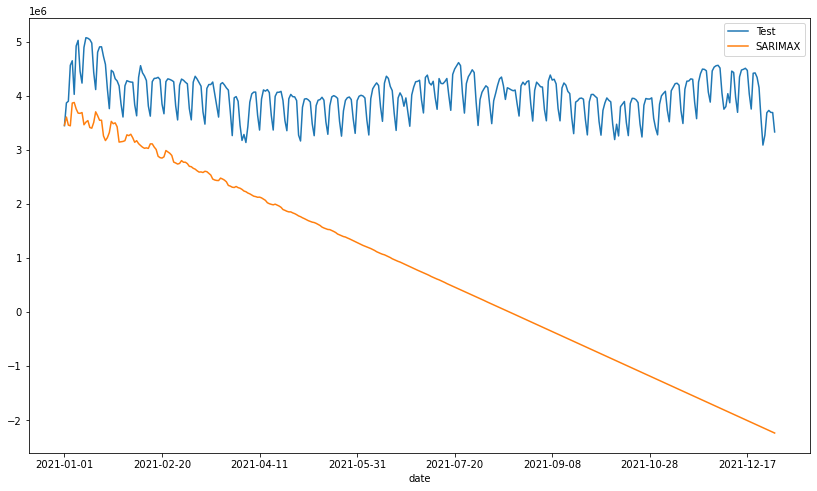

In [ ]:
test_sarimax['value'].plot(legend=True, label='Test', figsize=(14,8))
test_sarimax['value_sarimax'].plot(legend=True, label='SARIMAX', figsize=(14,8))

In [ ]:
mae_sarimax = mean_absolute_error(test_sarimax['value'], test_sarimax['value_sarimax'])
mse_sarimax = mean_squared_error(test_sarimax['value'], test_sarimax['value_sarimax'])
rmse_sarimax = np.sqrt(mean_squared_error(test_sarimax['value'], test_sarimax['value_sarimax']))
mape_sarimax = mean_absolute_percentage_error(test_sarimax['value'], test_sarimax['value_sarimax'])
smape_sarimax = smape(test_sarimax['value'], test_sarimax['value_sarimax'])
mase_sarimax = mase(train_sarimax['value'], test_sarimax['value'], test_sarimax['value_sarimax'])

print(f'MAE: {mae_sarimax:11.10}')
print(f'MSE: {mse_sarimax:11.10}')
print(f'RMSE: {rmse_sarimax:11.10}')
print('----------------------')
print(f'MAPE: {mape_sarimax:11.10}')
print(f'sMAPE: {smape_sarimax:11.10}')
print('----------------------')
print(f'MASE: {mase_sarimax:11.10}')

MAE: 3251067.917
MSE: 1.348398815e+13
RMSE:  3672055.03
----------------------
MAPE: 0.8159125011
sMAPE: 126.3342763
----------------------
MASE: 13.37008416


### Working day como variable exógena

In [ ]:
train_sarimax = energy_demand_daily.loc['2014':'2021']
train_sarimax

,value,weekday,working_day
date,,,
2014-01-01,3315035.0,2,0
2014-01-02,4059590.0,3,1
2014-01-03,4098986.0,4,1
2014-01-04,3867911.0,5,1
2014-01-05,3648038.0,6,1
...,...,...,...
2020-12-27,3687140.0,6,1
2020-12-28,4149036.0,0,1
2020-12-29,4185143.0,1,1


In [ ]:
test_sarimax = energy_demand_daily.loc['2021':'2022']
test_sarimax

,value,weekday,working_day
date,,,
2021-01-01,3447073.0,4,0
2021-01-02,3867892.0,5,1
2021-01-03,3899502.0,6,1
2021-01-04,4563905.0,0,1
2021-01-05,4647728.0,1,1
...,...,...,...
2021-12-27,3686647.0,0,1
2021-12-28,3729169.0,1,1
2021-12-29,3692921.0,2,1


In [ ]:
exo_train = train_sarimax

del exo_train['value']
del exo_train['weekday']

exo_train

,working_day
date,
2014-01-01,0
2014-01-02,1
2014-01-03,1
2014-01-04,1
2014-01-05,1
...,...
2020-12-27,1
2020-12-28,1
2020-12-29,1


In [ ]:
exo_test = test_sarimax

del exo_test['value']
del exo_test['weekday']

exo_test

,working_day
date,
2021-01-01,0
2021-01-02,1
2021-01-03,1
2021-01-04,1
2021-01-05,1
...,...
2021-12-27,1
2021-12-28,1
2021-12-29,1


In [ ]:
train_sarimax = energy_demand_daily.loc['2014':'2021']

del train_sarimax['working_day']
del train_sarimax['weekday']

train_sarimax

,value
date,
2014-01-01,3315035.0
2014-01-02,4059590.0
2014-01-03,4098986.0
2014-01-04,3867911.0
2014-01-05,3648038.0
...,...
2020-12-27,3687140.0
2020-12-28,4149036.0
2020-12-29,4185143.0


In [ ]:
test_sarimax = energy_demand_daily.loc['2021':'2022']

del test_sarimax['working_day']
del test_sarimax['weekday']

test_sarimax

,value
date,
2021-01-01,3447073.0
2021-01-02,3867892.0
2021-01-03,3899502.0
2021-01-04,4563905.0
2021-01-05,4647728.0
...,...
2021-12-27,3686647.0
2021-12-28,3729169.0
2021-12-29,3692921.0


In [ ]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
s = 4

from itertools import product

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [ ]:
result_df = optimize_SARIMAX(train_sarimax, exo_train, parameters_list, d, D, s)
# result_df

/tmp/ipykernel_26940/2332496891.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/256 [00:00<?, ?it/s]

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: Convergence

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: Convergence

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/berni/anaconda3/lib/python3.8/site-packages/statsm

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.p

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524

In [ ]:
result_df

,"(p,q,P,Q)",AIC
0,"(3, 2, 3, 3)",68582.465219
1,"(3, 2, 3, 2)",68725.223056
2,"(2, 2, 3, 3)",68951.372986
3,"(3, 2, 3, 1)",69160.244902
4,"(3, 2, 2, 1)",69187.676405
...,...,...
250,"(1, 0, 2, 0)",72043.030974
251,"(1, 0, 1, 0)",72044.647335
252,"(0, 1, 0, 0)",72064.722208
253,"(1, 0, 0, 0)",72080.398958


In [ ]:
# p, d, q
# P, D, Q, s

# (p,q,P,Q) = (3, 2, 3, 3)

# order = (p,d,q) = (3, 2, 1)
# seasonal_order = (P,D,Q,s) = (3, 0, 3, 4)

model_sarimax = SARIMAX(
    train_sarimax,
    exo_train,
    order=(3, 2, 1),
    seasonal_order=(3, 0, 3, 4)
).fit()

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.42397D+01    |proj g|=  2.19122D-01

At iterate    5    f=  1.40020D+01    |proj g|=  1.13259D-01

At iterate   10    f=  1.39186D+01    |proj g|=  8.89187D-02

At iterate   15    f=  1.39020D+01    |proj g|=  3.82218D-01

At iterate   20    f=  1.38937D+01    |proj g|=  8.37449D-02

At iterate   25    f=  1.38902D+01    |proj g|=  2.47523D-02

At iterate   30    f=  1.38879D+01    |proj g|=  1.00708D-01

At iterate   35    f=  1.38875D+01    |proj g|=  3.81217D-02

At iterate   40    f=  1.38873D+01    |proj g|=  1.38669D-01

At iterate   45    f=  1.38864D+01    |proj g|=  1.96252D-02

At iterate   50    f=  1.38855D+01    |proj g|=  4.32537D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
model_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                         
=================================================================================================
Dep. Variable:                                     value   No. Observations:                 2557
Model:             SARIMAX(3, 2, 1)x(3, 0, [1, 2, 3], 4)   Log Likelihood              -35505.167
Date:                                   Fri, 08 Jul 2022   AIC                          71034.334
Time:                                           18:47:31   BIC                          71104.483
Sample:                                       01-01-2014   HQIC                         71059.773
                                            - 12-31-2020                                         
Covariance Type:                                     opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
working_day  3.378e+05   1.43e-08   2.36e+13      0.000    3.38e+05    3.38e+05
ar.L1           0.1921      0.045      4.270      0.000       0.104       0.280
ar.L2           0.0072      0.037      0.193      0.847      -0.066       0.080
ar.L3          -0.5916      0.043    -13.636      0.000      -0.677      -0.507
ma.L1          -0.9975      0.022    -45.724      0.000      -1.040      -0.955
ar.S.L4         0.2549      0.016     15.893      0.000       0.223       0.286
ar.S.L8         0.2370      0.020     11.916      0.000       0.198       0.276
ar.S.L12       -0.9914      0.016    -62.011      0.000      -1.023      -0.960
ma.S.L4        -0.2465      0.054     -4.571      0.000      -0.352      -0.141
ma.S.L8        -0.2629      0.065     -4.037      0.000      -0.391      -0.135
ma.S.L12        0.9834      0.053     18.717      0.000       0.880       1.086
sigma2        1.37e+11    1.3e-12   1.06e+23      0.000    1.37e+11    1.37e+11
===================================================================================
Ljung-Box (L1) (Q):                 338.13   Jarque-Bera (JB):                50.29
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.69e+36. Standard errors may be unstable.
"""

In [ ]:
y_pred_sarimax = model_sarimax.predict(start='2021-01-01', end='2021-12-31', exog = exo_test, dynamic=True)
y_pred_sarimax

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


2021-01-01    3.666450e+06
2021-01-02    3.634319e+06
2021-01-03    3.769622e+06
2021-01-04    4.120638e+06
2021-01-05    4.254867e+06
                  ...     
2021-12-27    4.009647e+06
2021-12-28    3.997770e+06
2021-12-29    3.761978e+06
2021-12-30    3.879332e+06
2021-12-31    4.084630e+06
Freq: D, Name: predicted_mean, Length: 365, dtype: float64

In [ ]:
test_sarimax['value_sarimax'] = np.asarray(y_pred_sarimax)

/tmp/ipykernel_13342/2905224860.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_sarimax['value_sarimax'] = np.asarray(y_pred_sarimax)


In [ ]:
test_sarimax

,value,value_sarimax
date,,
2021-01-01,3447073.0,3.666450e+06
2021-01-02,3867892.0,3.634319e+06
2021-01-03,3899502.0,3.769622e+06
2021-01-04,4563905.0,4.120638e+06
2021-01-05,4647728.0,4.254867e+06
...,...,...
2021-12-27,3686647.0,4.009647e+06
2021-12-28,3729169.0,3.997770e+06
2021-12-29,3692921.0,3.761978e+06


<AxesSubplot:xlabel='date'>

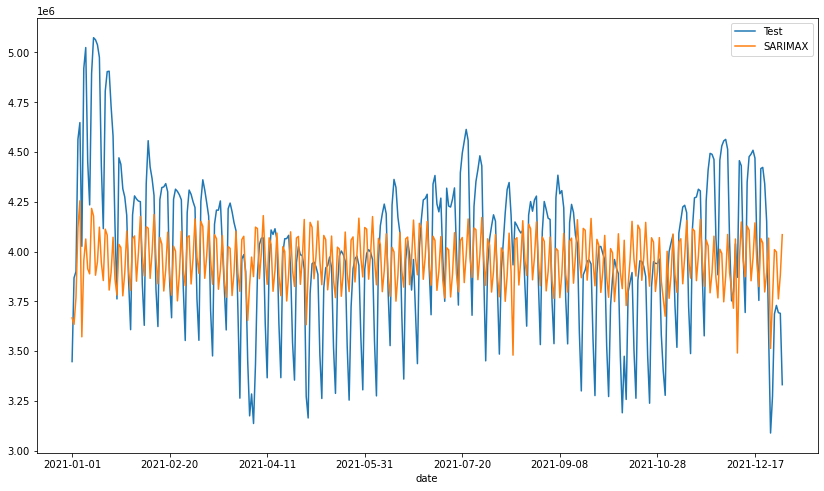

In [ ]:
test_sarimax['value'].plot(legend=True, label='Test', figsize=(14,8))
test_sarimax['value_sarimax'].plot(legend=True, label='SARIMAX', figsize=(14,8))

In [ ]:
mae_sarimax_original = mean_absolute_error(test_sarimax['value'], test_sarimax['value_sarimax'])
mse_sarimax_original = mean_squared_error(test_sarimax['value'], test_sarimax['value_sarimax'])
rmse_sarimax_original = np.sqrt(mean_squared_error(test_sarimax['value'], test_sarimax['value_sarimax']))
mape_sarimax_original = mean_absolute_percentage_error(test_sarimax['value'], test_sarimax['value_sarimax'])
smape_sarimax_original = smape(test_sarimax['value'], test_sarimax['value_sarimax'])
mase_sarimax_original = mase(train_sarimax['value'], test_sarimax['value'], test_sarimax['value_sarimax'])

print(f'MAE: {mae_sarimax_original:11.10}')
print(f'MSE: {mse_sarimax_original:11.10}')
print(f'RMSE: {rmse_sarimax_original:11.10}')
print('----------------------')
print(f'MAPE: {mape_sarimax_original:11.10}')
print(f'sMAPE: {smape_sarimax_original:11.10}')
print('----------------------')
print(f'MASE: {mase_sarimax_original:11.10}')

MAE: 279673.3795
MSE: 1.212654134e+11
RMSE: 348231.8386
----------------------
MAPE: 0.07004791899
sMAPE:  7.03848178
----------------------
MASE: 1.150162567


## Pruebas con weekday y working_day

In [ ]:
train_sarimax = energy_demand_daily.loc['2014':'2021']
test_sarimax = energy_demand_daily.loc['2021':'2022']

In [ ]:
exo_train = train_sarimax

del exo_train['value']

In [ ]:
exo_test = test_sarimax

del exo_test['value']

In [ ]:
train_sarimax = energy_demand_daily.loc['2014':'2021']

del train_sarimax['working_day']
del train_sarimax['weekday']

test_sarimax = energy_demand_daily.loc['2021':'2022']

del test_sarimax['working_day']
del test_sarimax['weekday']

In [ ]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
s = 4

from itertools import product

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [ ]:
result_df = optimize_SARIMAX(train_sarimax, exo_train, parameters_list, d, D, s)

/tmp/ipykernel_26940/2332496891.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/256 [00:00<?, ?it/s]

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: Convergence

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: Convergence

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.p

In [ ]:
result_df

,"(p,q,P,Q)",AIC
0,"(2, 3, 2, 3)",67276.530480
1,"(2, 3, 2, 2)",67287.463465
2,"(3, 2, 3, 3)",67293.339798
3,"(2, 3, 3, 3)",67308.088891
4,"(3, 3, 2, 3)",67456.133394
...,...,...
251,"(0, 2, 0, 0)",69299.576980
252,"(1, 1, 0, 0)",69426.895766
253,"(0, 1, 0, 0)",69430.150356
254,"(1, 0, 0, 0)",69500.723413


In [ ]:
# p, d, q
# P, D, Q, s

# (p,q,P,Q) = (2, 3, 2, 3)

# order = (p,d,q) = (2, 2, 3)
# seasonal_order = (P,D,Q,s) = (2, 0, 3, 4)

model_sarimax = SARIMAX(
    train_sarimax,
    exo_train,
    order=(2, 2, 3),
    seasonal_order=(2, 0, 3, 4)
).fit()

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38979D+01    |proj g|=  4.45003D-01


 This problem is unconstrained.



At iterate    5    f=  1.34871D+01    |proj g|=  1.39452D-01

At iterate   10    f=  1.34538D+01    |proj g|=  4.90752D-02

At iterate   15    f=  1.34391D+01    |proj g|=  2.57103D-02

At iterate   20    f=  1.34367D+01    |proj g|=  1.36490D-02

At iterate   25    f=  1.34205D+01    |proj g|=  2.47845D-01

At iterate   30    f=  1.33847D+01    |proj g|=  2.54404D-01

At iterate   35    f=  1.33575D+01    |proj g|=  2.74420D-01

At iterate   40    f=  1.33552D+01    |proj g|=  4.09086D-02

At iterate   45    f=  1.33481D+01    |proj g|=  2.32608D-01


/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.33418D+01    |proj g|=  2.65558D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     65      1     0     0   2.656D-01   1.334D+01
  F =   13.341808009601289     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [ ]:
y_pred_sarimax = model_sarimax.predict(start='2021-01-01', end='2021-12-31', exog = exo_test, dynamic=True)
y_pred_sarimax

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


2021-01-01    3.455101e+06
2021-01-02    3.549442e+06
2021-01-03    3.286007e+06
2021-01-04    3.879599e+06
2021-01-05    3.907009e+06
                  ...     
2021-12-27    4.276674e+06
2021-12-28    4.248642e+06
2021-12-29    4.313710e+06
2021-12-30    4.317268e+06
2021-12-31    4.175893e+06
Freq: D, Name: predicted_mean, Length: 365, dtype: float64

In [ ]:
test_sarimax['value_sarimax'] = np.asarray(y_pred_sarimax)
test_sarimax

/tmp/ipykernel_13342/3738930373.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_sarimax['value_sarimax'] = np.asarray(y_pred_sarimax)


,value,value_sarimax
date,,
2021-01-01,3447073.0,3.455101e+06
2021-01-02,3867892.0,3.549442e+06
2021-01-03,3899502.0,3.286007e+06
2021-01-04,4563905.0,3.879599e+06
2021-01-05,4647728.0,3.907009e+06
...,...,...
2021-12-27,3686647.0,4.276674e+06
2021-12-28,3729169.0,4.248642e+06
2021-12-29,3692921.0,4.313710e+06


<AxesSubplot:xlabel='date'>

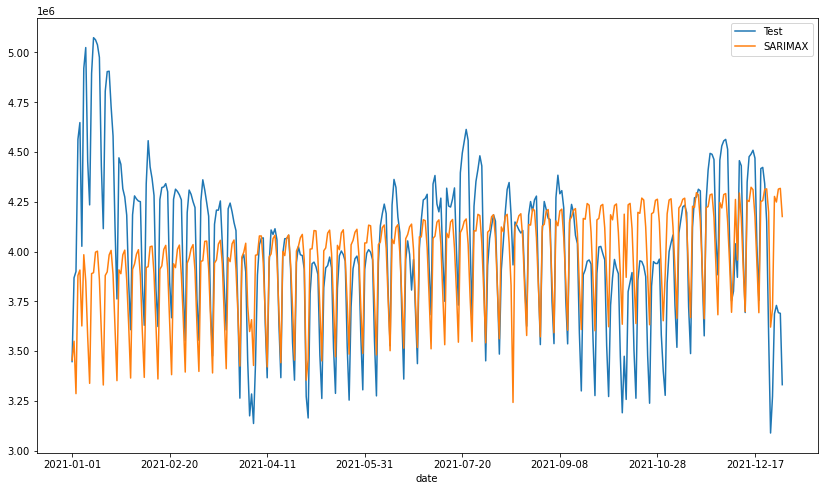

In [ ]:
test_sarimax['value'].plot(legend=True, label='Test', figsize=(14,8))
test_sarimax['value_sarimax'].plot(legend=True, label='SARIMAX', figsize=(14,8))

In [ ]:
rmse_sarimax_weekday = mean_squared_error(test_sarimax['value'], test_sarimax['value_sarimax'])
mape_sarimax_weekday = mean_absolute_percentage_error(test_sarimax['value'],test_sarimax['value_sarimax'])

print(f'RMSE: {rmse_sarimax_weekday:11.10}')
print(f'MAPE: {mape_sarimax_weekday:11.10}')

RMSE: 1.031150285e+11
MAPE: 0.05857627224


In [ ]:
mae_sarimax_weekday = mean_absolute_error(test_sarimax['value'], test_sarimax['value_sarimax'])
mse_sarimax_weekday = mean_squared_error(test_sarimax['value'], test_sarimax['value_sarimax'])
rmse_sarimax_weekday = np.sqrt(mean_squared_error(test_sarimax['value'], test_sarimax['value_sarimax']))
mape_sarimax_weekday = mean_absolute_percentage_error(test_sarimax['value'], test_sarimax['value_sarimax'])
smape_sarimax_weekday = smape(test_sarimax['value'], test_sarimax['value_sarimax'])
mase_sarimax_weekday = mase(train_sarimax['value'], test_sarimax['value'], test_sarimax['value_sarimax'])

print(f'MAE: {mae_sarimax_weekday:11.10}')
print(f'MSE: {mse_sarimax_weekday:11.10}')
print(f'RMSE: {rmse_sarimax_weekday:11.10}')
print('----------------------')
print(f'MAPE: {mape_sarimax_weekday:11.10}')
print(f'sMAPE: {smape_sarimax_weekday:11.10}')
print('----------------------')
print(f'MASE: {mase_sarimax_weekday:11.10}')

MAE: 237107.1042
MSE: 1.031150285e+11
RMSE: 321115.2885
----------------------
MAPE: 0.05857627224
sMAPE: 5.936616965
----------------------
MASE: 0.9751078779


## Pruebas con weekday, working_day y temperatura

In [ ]:
train_sarimax = energy_demand_daily_temp.loc['2014':'2021']
train_sarimax

,value,weekday,working_day,madrid_temp,barcelona_temp,bilbao_temp,sevilla_temp,valencia_temp
date,,,,,,,,
2014-01-01,3315035.0,2.0,0.0,6.785193,8.006851,11.418970,12.184413,13.189499
2014-01-02,4059590.0,3.0,1.0,9.109185,10.764683,12.935602,14.524325,15.136449
2014-01-03,4098986.0,4.0,1.0,9.776889,11.935958,13.029657,15.653018,16.565861
2014-01-04,3867911.0,5.0,1.0,6.703811,11.307489,9.814500,14.106683,14.699295
2014-01-05,3648038.0,6.0,1.0,5.285333,8.682916,9.971085,10.653680,10.970076
...,...,...,...,...,...,...,...,...
2020-12-27,3687140.0,6.0,1.0,1.845615,5.074426,7.337875,7.333795,8.264887
2020-12-28,4149036.0,0.0,1.0,5.030428,8.714899,7.470769,10.717422,11.297570
2020-12-29,4185143.0,1.0,1.0,2.841488,7.956539,5.964505,8.562127,9.813002


In [ ]:
test_sarimax = energy_demand_daily_temp.loc['2021':'2022']
test_sarimax

,value,weekday,working_day,madrid_temp,barcelona_temp,bilbao_temp,sevilla_temp,valencia_temp
date,,,,,,,,
2021-01-01,3447073.0,4.0,0.0,2.184065,6.170630,4.822402,8.808740,9.047967
2021-01-02,3867892.0,5.0,1.0,0.537135,5.119815,3.427820,6.213597,7.486780
2021-01-03,3899502.0,6.0,1.0,0.814590,5.368504,4.247380,4.972193,7.664697
2021-01-04,4563905.0,0.0,1.0,0.781345,3.936111,3.047703,6.441625,7.268713
2021-01-05,4647728.0,1.0,1.0,0.119664,3.608848,3.347874,6.642948,6.059656
...,...,...,...,...,...,...,...,...
2021-12-27,3686647.0,0.0,1.0,11.606002,13.531011,14.285517,17.009720,17.443636
2021-12-28,3729169.0,1.0,1.0,9.792129,14.261092,14.133620,16.015375,16.007968
2021-12-29,3692921.0,2.0,1.0,8.401157,13.250848,12.936356,13.320164,15.173263


In [ ]:
exo_train = train_sarimax

del exo_train['value']

exo_train

,weekday,working_day,madrid_temp,barcelona_temp,bilbao_temp,sevilla_temp,valencia_temp
date,,,,,,,
2014-01-01,2.0,0.0,6.785193,8.006851,11.418970,12.184413,13.189499
2014-01-02,3.0,1.0,9.109185,10.764683,12.935602,14.524325,15.136449
2014-01-03,4.0,1.0,9.776889,11.935958,13.029657,15.653018,16.565861
2014-01-04,5.0,1.0,6.703811,11.307489,9.814500,14.106683,14.699295
2014-01-05,6.0,1.0,5.285333,8.682916,9.971085,10.653680,10.970076
...,...,...,...,...,...,...,...
2020-12-27,6.0,1.0,1.845615,5.074426,7.337875,7.333795,8.264887
2020-12-28,0.0,1.0,5.030428,8.714899,7.470769,10.717422,11.297570
2020-12-29,1.0,1.0,2.841488,7.956539,5.964505,8.562127,9.813002


In [ ]:
exo_test = test_sarimax

del exo_test['value']

exo_test

,weekday,working_day,madrid_temp,barcelona_temp,bilbao_temp,sevilla_temp,valencia_temp
date,,,,,,,
2021-01-01,4.0,0.0,2.184065,6.170630,4.822402,8.808740,9.047967
2021-01-02,5.0,1.0,0.537135,5.119815,3.427820,6.213597,7.486780
2021-01-03,6.0,1.0,0.814590,5.368504,4.247380,4.972193,7.664697
2021-01-04,0.0,1.0,0.781345,3.936111,3.047703,6.441625,7.268713
2021-01-05,1.0,1.0,0.119664,3.608848,3.347874,6.642948,6.059656
...,...,...,...,...,...,...,...
2021-12-27,0.0,1.0,11.606002,13.531011,14.285517,17.009720,17.443636
2021-12-28,1.0,1.0,9.792129,14.261092,14.133620,16.015375,16.007968
2021-12-29,2.0,1.0,8.401157,13.250848,12.936356,13.320164,15.173263


In [ ]:
train_sarimax = energy_demand_daily_temp.loc['2014':'2021']

del train_sarimax['working_day']
del train_sarimax['weekday']
del train_sarimax['madrid_temp']
del train_sarimax['barcelona_temp']
del train_sarimax['bilbao_temp']
del train_sarimax['sevilla_temp']
del train_sarimax['valencia_temp']

train_sarimax

,value
date,
2014-01-01,3315035.0
2014-01-02,4059590.0
2014-01-03,4098986.0
2014-01-04,3867911.0
2014-01-05,3648038.0
...,...
2020-12-27,3687140.0
2020-12-28,4149036.0
2020-12-29,4185143.0


In [ ]:
test_sarimax = energy_demand_daily_temp.loc['2021':'2022']

del test_sarimax['working_day']
del test_sarimax['weekday']
del test_sarimax['madrid_temp']
del test_sarimax['barcelona_temp']
del test_sarimax['bilbao_temp']
del test_sarimax['sevilla_temp']
del test_sarimax['valencia_temp']

test_sarimax

,value
date,
2021-01-01,3447073.0
2021-01-02,3867892.0
2021-01-03,3899502.0
2021-01-04,4563905.0
2021-01-05,4647728.0
...,...
2021-12-27,3686647.0
2021-12-28,3729169.0
2021-12-29,3692921.0


In [ ]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
s = 4

from itertools import product

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [ ]:
result_df_temp = optimize_SARIMAX(train_sarimax, exo_train, parameters_list, d, D, s)

/tmp/ipykernel_26940/2332496891.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/256 [00:00<?, ?it/s]

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: Convergence

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: Convergence

In [ ]:
result_df_temp

,"(p,q,P,Q)",AIC
0,"(3, 2, 3, 3)",67260.373367
1,"(3, 3, 2, 3)",67289.385989
2,"(2, 3, 3, 3)",67341.403810
3,"(2, 3, 2, 3)",67408.837265
4,"(3, 3, 3, 3)",67448.403538
...,...,...
251,"(0, 2, 0, 0)",69303.107219
252,"(1, 1, 0, 0)",69433.093267
253,"(0, 1, 0, 0)",69436.381944
254,"(1, 0, 0, 0)",69503.344536


In [ ]:
# p, d, q
# P, D, Q, s

# (p,q,P,Q) = (3, 2, 3, 3)

# order = (p,d,q) = (3, 2, 3)
# seasonal_order = (P,D,Q,s) = (3, 0, 3, 4)

model_sarimax = SARIMAX(
    train_sarimax,
    exo_train,
    order=(3, 2, 3),
    seasonal_order=(3, 0, 3, 4)
).fit()

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38421D+01    |proj g|=  4.68201D-01

At iterate    5    f=  1.34994D+01    |proj g|=  6.61134D-02

At iterate   10    f=  1.34062D+01    |proj g|=  1.05130D-01

At iterate   15    f=  1.33725D+01    |proj g|=  7.77696D-02

At iterate   20    f=  1.33540D+01    |proj g|=  3.28739D-01

At iterate   25    f=  1.33414D+01    |proj g|=  1.68580D-01

At iterate   30    f=  1.33377D+01    |proj g|=  4.91962D-02

At iterate   35    f=  1.33301D+01    |proj g|=  3.66950D-02

At iterate   40    f=  1.33289D+01    |proj g|=  1.92145D-02

At iterate   45    f=  1.33284D+01    |proj g|=  1.33769D-01


/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.33281D+01    |proj g|=  3.04593D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     69      1     0     0   3.046D-02   1.333D+01
  F =   13.328077336567455     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [ ]:
y_pred_sarimax = model_sarimax.predict(start='2021-01-01', end='2021-12-31', exog = exo_test, dynamic=True)
y_pred_sarimax

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


2021-01-01    3.413115e+06
2021-01-02    3.518809e+06
2021-01-03    3.229583e+06
2021-01-04    3.768045e+06
2021-01-05    3.862365e+06
                  ...     
2021-12-27    4.289509e+06
2021-12-28    4.300596e+06
2021-12-29    4.393888e+06
2021-12-30    4.412636e+06
2021-12-31    4.255676e+06
Freq: D, Name: predicted_mean, Length: 365, dtype: float64

In [ ]:
test_sarimax['value_sarimax'] = np.asarray(y_pred_sarimax)
test_sarimax

/tmp/ipykernel_13342/3738930373.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_sarimax['value_sarimax'] = np.asarray(y_pred_sarimax)


,value,value_sarimax
date,,
2021-01-01,3447073.0,3.413115e+06
2021-01-02,3867892.0,3.518809e+06
2021-01-03,3899502.0,3.229583e+06
2021-01-04,4563905.0,3.768045e+06
2021-01-05,4647728.0,3.862365e+06
...,...,...
2021-12-27,3686647.0,4.289509e+06
2021-12-28,3729169.0,4.300596e+06
2021-12-29,3692921.0,4.393888e+06


<AxesSubplot:xlabel='date'>

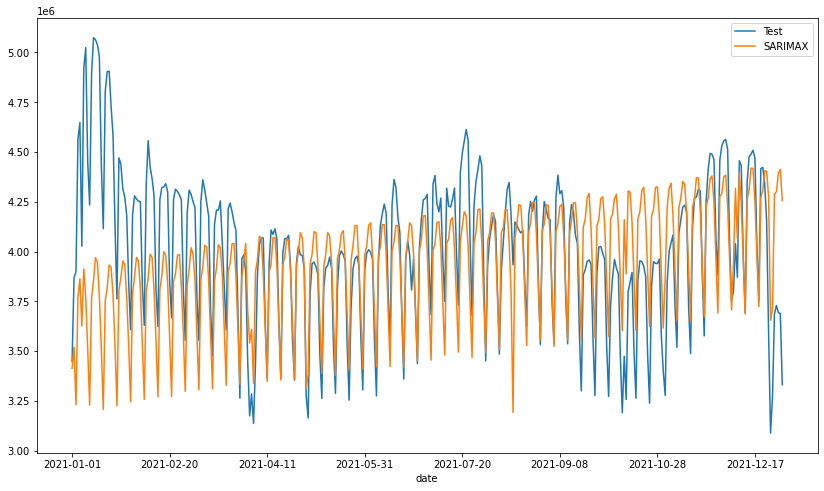

In [ ]:
test_sarimax['value'].plot(legend=True, label='Test', figsize=(14,8))
test_sarimax['value_sarimax'].plot(legend=True, label='SARIMAX', figsize=(14,8))

In [ ]:
rmse_sarimax_temp = mean_squared_error(test_sarimax['value'], test_sarimax['value_sarimax'])
mape_sarimax_temp = mean_absolute_percentage_error(test_sarimax['value'],test_sarimax['value_sarimax'])

print(f'RMSE: {rmse_sarimax_temp:11.10}')
print(f'MAPE: {mape_sarimax_temp:11.10}')

RMSE: 1.186571355e+11
MAPE: 0.06119586967


In [ ]:
mae_sarimax_weekday_temp = mean_absolute_error(test_sarimax['value'], test_sarimax['value_sarimax'])
mse_sarimax_weekday_temp = mean_squared_error(test_sarimax['value'], test_sarimax['value_sarimax'])
rmse_sarimax_weekday_temp = np.sqrt(mean_squared_error(test_sarimax['value'], test_sarimax['value_sarimax']))
mape_sarimax_weekday_temp = mean_absolute_percentage_error(test_sarimax['value'], test_sarimax['value_sarimax'])
smape_sarimax_weekday_temp = smape(test_sarimax['value'], test_sarimax['value_sarimax'])
mase_sarimax_weekday_temp = mase(train_sarimax['value'], test_sarimax['value'], test_sarimax['value_sarimax'])

print(f'MAE: {mae_sarimax_weekday_temp:11.10}')
print(f'MSE: {mse_sarimax_weekday_temp:11.10}')
print(f'RMSE: {rmse_sarimax_weekday_temp:11.10}')
print('----------------------')
print(f'MAPE: {mape_sarimax_weekday_temp:11.10}')
print(f'sMAPE: {smape_sarimax_weekday_temp:11.10}')
print('----------------------')
print(f'MASE: {mase_sarimax_weekday_temp:11.10}')

MAE: 248888.9476
MSE: 1.186571355e+11
RMSE: 344466.4505
----------------------
MAPE: 0.06119586967
sMAPE: 6.243520702
----------------------
MASE: 1.023560953


## Pruebas con weekday, working_day, temperatura y estacionalidad

In [ ]:
train_sarimax = energy_demand_daily_temp_seasonal.loc['2014':'2021']
train_sarimax

,value,weekday,working_day,madrid_temp,barcelona_temp,bilbao_temp,sevilla_temp,valencia_temp,is_winter,is_summer
date,,,,,,,,,,
2014-01-01,3315035.0,2.0,0.0,6.785193,8.006851,11.418970,12.184413,13.189499,1,0
2014-01-02,4059590.0,3.0,1.0,9.109185,10.764683,12.935602,14.524325,15.136449,1,0
2014-01-03,4098986.0,4.0,1.0,9.776889,11.935958,13.029657,15.653018,16.565861,1,0
2014-01-04,3867911.0,5.0,1.0,6.703811,11.307489,9.814500,14.106683,14.699295,1,0
2014-01-05,3648038.0,6.0,1.0,5.285333,8.682916,9.971085,10.653680,10.970076,1,0
...,...,...,...,...,...,...,...,...,...,...
2020-12-27,3687140.0,6.0,1.0,1.845615,5.074426,7.337875,7.333795,8.264887,0,0
2020-12-28,4149036.0,0.0,1.0,5.030428,8.714899,7.470769,10.717422,11.297570,0,0
2020-12-29,4185143.0,1.0,1.0,2.841488,7.956539,5.964505,8.562127,9.813002,0,0


In [ ]:
test_sarimax = energy_demand_daily_temp_seasonal.loc['2021':'2022']
test_sarimax

,value,weekday,working_day,madrid_temp,barcelona_temp,bilbao_temp,sevilla_temp,valencia_temp,is_winter,is_summer
date,,,,,,,,,,
2021-01-01,3447073.0,4.0,0.0,2.184065,6.170630,4.822402,8.808740,9.047967,0,0
2021-01-02,3867892.0,5.0,1.0,0.537135,5.119815,3.427820,6.213597,7.486780,0,0
2021-01-03,3899502.0,6.0,1.0,0.814590,5.368504,4.247380,4.972193,7.664697,0,0
2021-01-04,4563905.0,0.0,1.0,0.781345,3.936111,3.047703,6.441625,7.268713,0,0
2021-01-05,4647728.0,1.0,1.0,0.119664,3.608848,3.347874,6.642948,6.059656,0,0
...,...,...,...,...,...,...,...,...,...,...
2021-12-27,3686647.0,0.0,1.0,11.606002,13.531011,14.285517,17.009720,17.443636,1,0
2021-12-28,3729169.0,1.0,1.0,9.792129,14.261092,14.133620,16.015375,16.007968,1,0
2021-12-29,3692921.0,2.0,1.0,8.401157,13.250848,12.936356,13.320164,15.173263,1,0


In [ ]:
exo_train = train_sarimax

del exo_train['value']

exo_train

,weekday,working_day,madrid_temp,barcelona_temp,bilbao_temp,sevilla_temp,valencia_temp,is_winter,is_summer
date,,,,,,,,,
2014-01-01,2.0,0.0,6.785193,8.006851,11.418970,12.184413,13.189499,1,0
2014-01-02,3.0,1.0,9.109185,10.764683,12.935602,14.524325,15.136449,1,0
2014-01-03,4.0,1.0,9.776889,11.935958,13.029657,15.653018,16.565861,1,0
2014-01-04,5.0,1.0,6.703811,11.307489,9.814500,14.106683,14.699295,1,0
2014-01-05,6.0,1.0,5.285333,8.682916,9.971085,10.653680,10.970076,1,0
...,...,...,...,...,...,...,...,...,...
2020-12-27,6.0,1.0,1.845615,5.074426,7.337875,7.333795,8.264887,0,0
2020-12-28,0.0,1.0,5.030428,8.714899,7.470769,10.717422,11.297570,0,0
2020-12-29,1.0,1.0,2.841488,7.956539,5.964505,8.562127,9.813002,0,0


In [ ]:
cols = ['weekday', 'working_day', 'is_winter',
        'is_summer', 'madrid_temp', 'barcelona_temp',
        'bilbao_temp', 'sevilla_temp', 'valencia_temp'
]
exo_train = exo_train[cols]
exo_train

,weekday,working_day,is_winter,is_summer,madrid_temp,barcelona_temp,bilbao_temp,sevilla_temp,valencia_temp
date,,,,,,,,,
2014-01-01,2.0,0.0,1,0,6.785193,8.006851,11.418970,12.184413,13.189499
2014-01-02,3.0,1.0,1,0,9.109185,10.764683,12.935602,14.524325,15.136449
2014-01-03,4.0,1.0,1,0,9.776889,11.935958,13.029657,15.653018,16.565861
2014-01-04,5.0,1.0,1,0,6.703811,11.307489,9.814500,14.106683,14.699295
2014-01-05,6.0,1.0,1,0,5.285333,8.682916,9.971085,10.653680,10.970076
...,...,...,...,...,...,...,...,...,...
2020-12-27,6.0,1.0,0,0,1.845615,5.074426,7.337875,7.333795,8.264887
2020-12-28,0.0,1.0,0,0,5.030428,8.714899,7.470769,10.717422,11.297570
2020-12-29,1.0,1.0,0,0,2.841488,7.956539,5.964505,8.562127,9.813002


In [ ]:
exo_test = test_sarimax

del exo_test['value']

exo_test

,weekday,working_day,madrid_temp,barcelona_temp,bilbao_temp,sevilla_temp,valencia_temp,is_winter,is_summer
date,,,,,,,,,
2021-01-01,4.0,0.0,2.184065,6.170630,4.822402,8.808740,9.047967,0,0
2021-01-02,5.0,1.0,0.537135,5.119815,3.427820,6.213597,7.486780,0,0
2021-01-03,6.0,1.0,0.814590,5.368504,4.247380,4.972193,7.664697,0,0
2021-01-04,0.0,1.0,0.781345,3.936111,3.047703,6.441625,7.268713,0,0
2021-01-05,1.0,1.0,0.119664,3.608848,3.347874,6.642948,6.059656,0,0
...,...,...,...,...,...,...,...,...,...
2021-12-27,0.0,1.0,11.606002,13.531011,14.285517,17.009720,17.443636,1,0
2021-12-28,1.0,1.0,9.792129,14.261092,14.133620,16.015375,16.007968,1,0
2021-12-29,2.0,1.0,8.401157,13.250848,12.936356,13.320164,15.173263,1,0


In [ ]:
cols = ['weekday', 'working_day', 'is_winter',
        'is_summer', 'madrid_temp', 'barcelona_temp',
        'bilbao_temp', 'sevilla_temp', 'valencia_temp'
]
exo_test = exo_test[cols]
exo_test

,weekday,working_day,is_winter,is_summer,madrid_temp,barcelona_temp,bilbao_temp,sevilla_temp,valencia_temp
date,,,,,,,,,
2021-01-01,4.0,0.0,0,0,2.184065,6.170630,4.822402,8.808740,9.047967
2021-01-02,5.0,1.0,0,0,0.537135,5.119815,3.427820,6.213597,7.486780
2021-01-03,6.0,1.0,0,0,0.814590,5.368504,4.247380,4.972193,7.664697
2021-01-04,0.0,1.0,0,0,0.781345,3.936111,3.047703,6.441625,7.268713
2021-01-05,1.0,1.0,0,0,0.119664,3.608848,3.347874,6.642948,6.059656
...,...,...,...,...,...,...,...,...,...
2021-12-27,0.0,1.0,1,0,11.606002,13.531011,14.285517,17.009720,17.443636
2021-12-28,1.0,1.0,1,0,9.792129,14.261092,14.133620,16.015375,16.007968
2021-12-29,2.0,1.0,1,0,8.401157,13.250848,12.936356,13.320164,15.173263


In [ ]:
train_sarimax = energy_demand_daily_temp_seasonal.loc['2014':'2021']

del train_sarimax['working_day']
del train_sarimax['weekday']
del train_sarimax['madrid_temp']
del train_sarimax['barcelona_temp']
del train_sarimax['bilbao_temp']
del train_sarimax['sevilla_temp']
del train_sarimax['valencia_temp']
del train_sarimax['is_winter']
del train_sarimax['is_summer']

train_sarimax

,value
date,
2014-01-01,3315035.0
2014-01-02,4059590.0
2014-01-03,4098986.0
2014-01-04,3867911.0
2014-01-05,3648038.0
...,...
2020-12-27,3687140.0
2020-12-28,4149036.0
2020-12-29,4185143.0


In [ ]:
test_sarimax = energy_demand_daily_temp_seasonal.loc['2021':'2022']

del test_sarimax['working_day']
del test_sarimax['weekday']
del test_sarimax['madrid_temp']
del test_sarimax['barcelona_temp']
del test_sarimax['bilbao_temp']
del test_sarimax['sevilla_temp']
del test_sarimax['valencia_temp']
del test_sarimax['is_winter']
del test_sarimax['is_summer']

test_sarimax

,value
date,
2021-01-01,3447073.0
2021-01-02,3867892.0
2021-01-03,3899502.0
2021-01-04,4563905.0
2021-01-05,4647728.0
...,...
2021-12-27,3686647.0
2021-12-28,3729169.0
2021-12-29,3692921.0


In [ ]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
s = 4

from itertools import product

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [ ]:
result_df_temp_seasonal = optimize_SARIMAX(train_sarimax, exo_train, parameters_list, d, D, s)

result_df_temp_seasonal

/tmp/ipykernel_2995/2332496891.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/256 [00:00<?, ?it/s]

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: Convergence

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: Val

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.p

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524

,"(p,q,P,Q)",AIC
0,"(3, 2, 3, 3)",67260.004387
1,"(3, 3, 2, 2)",67282.658028
2,"(2, 3, 3, 3)",67306.916836
3,"(3, 3, 2, 3)",67466.523422
4,"(3, 3, 3, 3)",67468.213426
...,...,...
251,"(0, 2, 0, 0)",69313.804315
252,"(1, 1, 0, 0)",69436.356289
253,"(0, 1, 0, 0)",69439.572537
254,"(1, 0, 0, 0)",69506.111009


In [ ]:
# p, d, q
# P, D, Q, s

# (p,q,P,Q) = (3, 2, 3, 3) Sale igual

# order = (p,d,q) = (3, 2, 3)
# seasonal_order = (P,D,Q,s) = (3, 0, 3, 4)

model_sarimax = SARIMAX(
    train_sarimax,
    exo_train,
    order=(3, 2, 3),
    seasonal_order=(3, 0, 3, 4),
    # initialization='approximate_diffuse' ,
    # enforce_stationarity=True
).fit()

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38416D+01    |proj g|=  4.70406D-01


 This problem is unconstrained.



At iterate    5    f=  1.35020D+01    |proj g|=  6.61587D-02

At iterate   10    f=  1.34113D+01    |proj g|=  1.30333D-01

At iterate   15    f=  1.33754D+01    |proj g|=  2.91490D-02

At iterate   20    f=  1.33644D+01    |proj g|=  1.22045D-01

At iterate   25    f=  1.33398D+01    |proj g|=  6.32304D-02

At iterate   30    f=  1.33357D+01    |proj g|=  5.64317D-02

At iterate   35    f=  1.33318D+01    |proj g|=  7.08253D-02

At iterate   40    f=  1.33296D+01    |proj g|=  8.77665D-02

At iterate   45    f=  1.33282D+01    |proj g|=  2.60568D-01


/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.33273D+01    |proj g|=  1.62803D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     78      1     0     0   1.628D-01   1.333D+01
  F =   13.327320376024240     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [ ]:
y_pred_sarimax = model_sarimax.predict(start='2021-01-01', end='2021-12-31', exog = exo_test, dynamic=True)
y_pred_sarimax

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


2021-01-01    3.411060e+06
2021-01-02    3.496871e+06
2021-01-03    3.210972e+06
2021-01-04    3.763006e+06
2021-01-05    3.845075e+06
                  ...     
2021-12-27    4.236011e+06
2021-12-28    4.245741e+06
2021-12-29    4.342756e+06
2021-12-30    4.365449e+06
2021-12-31    4.212057e+06
Freq: D, Name: predicted_mean, Length: 365, dtype: float64

In [ ]:
test_sarimax['value_sarimax'] = np.asarray(y_pred_sarimax)
test_sarimax

/tmp/ipykernel_13342/3738930373.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_sarimax['value_sarimax'] = np.asarray(y_pred_sarimax)


,value,value_sarimax
date,,
2021-01-01,3447073.0,3.411060e+06
2021-01-02,3867892.0,3.496871e+06
2021-01-03,3899502.0,3.210972e+06
2021-01-04,4563905.0,3.763006e+06
2021-01-05,4647728.0,3.845075e+06
...,...,...
2021-12-27,3686647.0,4.236011e+06
2021-12-28,3729169.0,4.245741e+06
2021-12-29,3692921.0,4.342756e+06


<AxesSubplot:xlabel='date'>

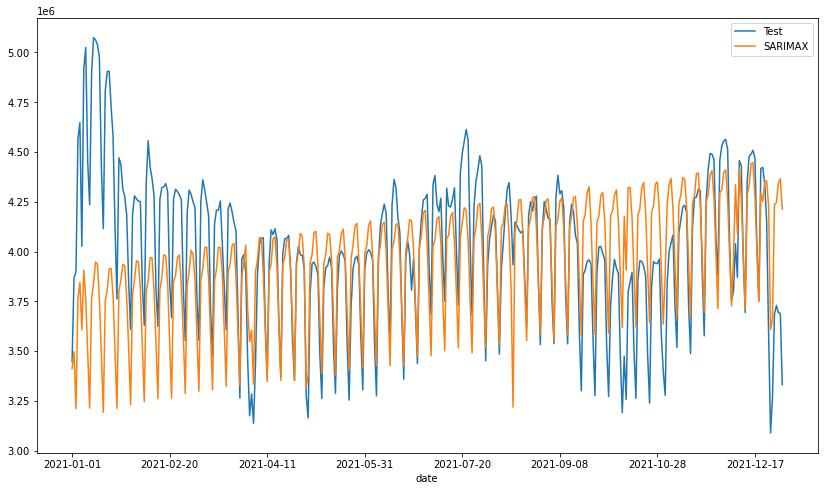

In [ ]:
test_sarimax['value'].plot(legend=True, label='Test', figsize=(14,8))
test_sarimax['value_sarimax'].plot(legend=True, label='SARIMAX', figsize=(14,8))

In [ ]:
rmse_sarimax_temp_seasonal = mean_squared_error(test_sarimax['value'], test_sarimax['value_sarimax'])
mape_sarimax_temp_seasonal = mean_absolute_percentage_error(test_sarimax['value'],test_sarimax['value_sarimax'])

print(f'RMSE: {rmse_sarimax_temp_seasonal:11.10}')
print(f'MAPE: {mape_sarimax_temp_seasonal:11.10}')

RMSE: 1.201113678e+11
MAPE: 0.06161137563


In [ ]:
mae_sarimax_weekday_temp_seasonal = mean_absolute_error(test_sarimax['value'], test_sarimax['value_sarimax'])
mse_sarimax_weekday_temp_seasonal = mean_squared_error(test_sarimax['value'], test_sarimax['value_sarimax'])
rmse_sarimax_weekday_temp_seasonal = np.sqrt(mean_squared_error(test_sarimax['value'], test_sarimax['value_sarimax']))
mape_sarimax_weekday_temp_seasonal = mean_absolute_percentage_error(test_sarimax['value'], test_sarimax['value_sarimax'])
smape_sarimax_weekday_temp_seasonal = smape(test_sarimax['value'], test_sarimax['value_sarimax'])
mase_sarimax_weekday_temp_seasonal = mase(train_sarimax['value'], test_sarimax['value'], test_sarimax['value_sarimax'])

print(f'MAE: {mae_sarimax_weekday_temp_seasonal:11.10}')
print(f'MSE: {mse_sarimax_weekday_temp_seasonal:11.10}')
print(f'RMSE: {rmse_sarimax_weekday_temp_seasonal:11.10}')
print('----------------------')
print(f'MAPE: {mape_sarimax_weekday_temp_seasonal:11.10}')
print(f'sMAPE: {smape_sarimax_weekday_temp_seasonal:11.10}')
print('----------------------')
print(f'MASE: {mase_sarimax_weekday_temp_seasonal:11.10}')

MAE: 250220.2585
MSE: 1.201113678e+11
RMSE: 346570.8698
----------------------
MAPE: 0.06161137563
sMAPE: 6.282534449
----------------------
MASE: 1.029035997


## Predicciones

In [ ]:
energy_demand_daily_temp_seasonal_2014_2022 = pd.read_csv('demanda_diaria_resume_2014_2022.csv')
energy_demand_daily_temp_seasonal_2014_2022.set_index("date", inplace=True)

energy_demand_daily_temp_seasonal_2014_2022.index.freq = 'D'

energy_demand_daily_temp_seasonal_2014_2022

,value,weekday,working_day,madrid_temp,barcelona_temp,bilbao_temp,sevilla_temp,valencia_temp,is_winter,is_summer
date,,,,,,,,,,
2014-01-01,3315035.0,2,0,4.69985,4.82314,7.79263,9.41128,10.86538,1,0
2014-01-01,3315035.0,2,0,4.59854,4.57510,6.95278,9.13394,10.87760,1,0
2014-01-01,3315035.0,2,0,4.65054,4.45498,6.63174,9.30117,10.91030,1,0
2014-01-01,3315035.0,2,0,4.71353,4.49868,7.63442,9.53726,10.86562,1,0
2014-01-01,3315035.0,2,0,4.80654,4.52236,9.08853,9.85757,10.86440,1,0
...,...,...,...,...,...,...,...,...,...,...
2022-02-28,3860129.0,0,1,12.50210,10.57730,13.41200,17.05532,12.37148,1,0
2022-02-28,3860129.0,0,1,10.96010,10.00160,10.66055,15.38467,11.31730,1,0
2022-02-28,3860129.0,0,1,9.48380,9.52505,9.47500,13.25698,10.29922,1,0


In [ ]:
energy_demand_daily_march_2022 = pd.read_csv('demanda_dataframe_marzo_2022.csv')
energy_demand_daily_march_2022.set_index("date", inplace=True)

energy_demand_daily_march_2022.index.freq = 'D'

energy_demand_daily_march_2022

,value,weekday,working_day,is_winter,is_summer
date,,,,,
2022-03-01,4134510.0,1,1,1,0
2022-03-02,4181750.0,2,1,1,0
2022-03-03,4226210.0,3,1,1,0
2022-03-04,4204637.0,4,1,1,0
2022-03-05,3722126.0,5,1,1,0
2022-03-06,3497731.0,6,1,1,0
2022-03-07,4173965.0,0,1,1,0
2022-03-08,4181348.0,1,1,1,0
2022-03-09,4132968.0,2,1,1,0


In [ ]:
################

In [ ]:
train_sarimax = pd.read_csv('demanda_diaria_resume_2014_2022.csv')
train_sarimax.set_index("date", inplace=True)
train_sarimax.index.freq = 'D'

train_sarimax

,value,weekday,working_day,madrid_temp,barcelona_temp,bilbao_temp,sevilla_temp,valencia_temp,is_winter,is_summer
date,,,,,,,,,,
2014-01-01,3315035.0,2,0,4.69985,4.82314,7.79263,9.41128,10.86538,1,0
2014-01-01,3315035.0,2,0,4.59854,4.57510,6.95278,9.13394,10.87760,1,0
2014-01-01,3315035.0,2,0,4.65054,4.45498,6.63174,9.30117,10.91030,1,0
2014-01-01,3315035.0,2,0,4.71353,4.49868,7.63442,9.53726,10.86562,1,0
2014-01-01,3315035.0,2,0,4.80654,4.52236,9.08853,9.85757,10.86440,1,0
...,...,...,...,...,...,...,...,...,...,...
2022-02-28,3860129.0,0,1,12.50210,10.57730,13.41200,17.05532,12.37148,1,0
2022-02-28,3860129.0,0,1,10.96010,10.00160,10.66055,15.38467,11.31730,1,0
2022-02-28,3860129.0,0,1,9.48380,9.52505,9.47500,13.25698,10.29922,1,0


In [ ]:
test_sarimax = pd.read_csv('demanda_dataframe_marzo_2022.csv')
test_sarimax.set_index("date", inplace=True)
test_sarimax.index.freq = 'D'
test_sarimax

,value,weekday,working_day,is_winter,is_summer
date,,,,,
2022-03-01,4134510.0,1,1,1,0
2022-03-02,4181750.0,2,1,1,0
2022-03-03,4226210.0,3,1,1,0
2022-03-04,4204637.0,4,1,1,0
2022-03-05,3722126.0,5,1,1,0
2022-03-06,3497731.0,6,1,1,0
2022-03-07,4173965.0,0,1,1,0
2022-03-08,4181348.0,1,1,1,0
2022-03-09,4132968.0,2,1,1,0


In [ ]:
exo_train = train_sarimax

del exo_train['value']
del exo_train['madrid_temp']
del exo_train['barcelona_temp']
del exo_train['bilbao_temp']
del exo_train['sevilla_temp']
del exo_train['valencia_temp']

cols = ['weekday', 'working_day', 'is_winter', 'is_summer']

exo_train = exo_train[cols]
exo_train

,weekday,working_day,is_winter,is_summer
date,,,,
2014-01-01,2,0,1,0
2014-01-01,2,0,1,0
2014-01-01,2,0,1,0
2014-01-01,2,0,1,0
2014-01-01,2,0,1,0
...,...,...,...,...
2022-02-28,0,1,1,0
2022-02-28,0,1,1,0
2022-02-28,0,1,1,0


In [ ]:
exo_test = pd.read_csv('demanda_dataframe_marzo_2022.csv')
exo_test.set_index("date", inplace=True)
exo_test.index.freq = 'D'

del exo_test['value']

# cols = ['weekday', 'working_day', 'is_winter', 'is_summer']

# exo_test = exo_test[cols]

exo_test

,weekday,working_day,is_winter,is_summer
date,,,,
2022-03-01,1,1,1,0
2022-03-02,2,1,1,0
2022-03-03,3,1,1,0
2022-03-04,4,1,1,0
2022-03-05,5,1,1,0
2022-03-06,6,1,1,0
2022-03-07,0,1,1,0
2022-03-08,1,1,1,0
2022-03-09,2,1,1,0


In [ ]:
train_sarimax = pd.read_csv('demanda_diaria_resume_2014_2022.csv')
train_sarimax.set_index("date", inplace=True)
train_sarimax.index.freq = 'D'

del train_sarimax['working_day']
del train_sarimax['weekday']
del train_sarimax['madrid_temp']
del train_sarimax['barcelona_temp']
del train_sarimax['bilbao_temp']
del train_sarimax['sevilla_temp']
del train_sarimax['valencia_temp']
del train_sarimax['is_winter']
del train_sarimax['is_summer']

train_sarimax

,value
date,
2014-01-01,3315035.0
2014-01-01,3315035.0
2014-01-01,3315035.0
2014-01-01,3315035.0
2014-01-01,3315035.0
...,...
2022-02-28,3860129.0
2022-02-28,3860129.0
2022-02-28,3860129.0


In [ ]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
s = 4

from itertools import product

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [ ]:
result_df_2014_2022 = optimize_SARIMAX(train_sarimax, exo_train, parameters_list, d, D, s)



/tmp/ipykernel_17618/2149124208.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/256 [00:00<?, ?it/s]

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been

In [ ]:
result_df_2014_2022